# <span style="color:rgb(0,162,162)"><strong>Sommaire</strong></span> <a class="anchor" id="0"></a>

* ## 0. [Define functions](#0)
* ## 1. [Introduction](#1)    
    * ### 1.1 [Project description](#1.1)    
    * ### 1.2 [Importing libraries](#1.2)
* ## 2. [Data Exploration](#2)
    * ### 2.1 [Number of pages](#2.1)
    * ### 2.2 [Ratings count](#2.2)
    * ### 2.3 [Text reviews count](#2.3)
    * ### 2.4 [Rating by reviews](#2.4)
    * ### 2.5 [Reviews by ratings](#2.5)
    * ### 2.6 [Publishers](#2.6)
    * ### 2.7 [Publication date](#2.7)
    * ### 2.8 [Authors](#2.8)
    * ### 2.9 [Features scaling](#2.9)
    * ### 2.10 [ISBN](#21.0)
* ## 3. [Training models](#3)
    * ### 3.1 [Linear Regression](#3.1)
    * ### 3.2 [Decision Tree](#3.2)
    * ### 3.3 [Random Forest](#3.3)
    * ### 3.4 [Gradient Boosting](#3.4)
    * ### 3.5 [PCA](#3.5)
* ## 4. [Models analysis](#4)

<a id="10"></a>
## [0. Define functions](#10)
[Sommaire](#0)

In [1]:
def show_models_perf(models_dict):
    for key, values in models_dict.items():
        print(key)
        for value in values:
            print()
            
def regression_metrics(y_true, y_pred, form=':.4d'):
    mse = metrics.mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = metrics.mean_absolute_error(y_true, y_pred)
    rmsle = np.sqrt(metrics.mean_squared_log_error(y_true, y_pred))
    r2 = metrics.r2_score(y_true, y_pred)
    print(f"RMSE : {rmse:.4f}\nMSE : {mse:.4f}\nMAE : {mae:.4f}\nR2 : {r2:.4f}\nRMSLE : {rmsle:.4f}")

## [1. Introduction](#1)<a id="1"></a>
[Sommaire](#0)    

### [1.1 Project description](#11)<a id="11"></a>
The aim of this project is to train a model that predict's a book rating.

### [1.2 Importing libraries](#1.2)<a id="12"></a>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pylab
import seaborn as sns
from scipy import stats
from sklearn import feature_selection
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import cross_validate, cross_val_score, train_test_split, KFold, RepeatedKFold, RepeatedStratifiedKFold, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn import metrics, tree
from graphviz import Source
from IPython.display import display, HTML
from sklearn.decomposition import PCA

display(HTML("<style>.container { width:100% !important; }</style>"))

<a id="2"></a>
## [2. Data Exploration](#2)
[Sommaire](#0)

In [3]:
def correct_list(line_list):
  '''
  Merge the third and the fourth element in a given list an return modified list

  :param line_list: list of items
  :return: corrected list
  '''
  line_list[2]="/".join(line_list[2:4])
  del(line_list[3])
  return line_list

# After identify the 4th lines causing problems, we can fix them.
with open('books.csv', 'r+', encoding='utf8') as fread:
  headers = fread.readline() # pass the headers
  lines = fread.readlines()

  list_file = [line.split(",") for line in lines]
  list_to_save = []
  for line_list in list_file:
    if len(line_list) != 12: 
      line_list = correct_list(line_list)


  [list_to_save.append(','.join(l)) for l in list_file]

# Saving the correct file
with open('books_preprocessed.csv', 'w+', encoding='utf8') as fwrite:
  fwrite.writelines(headers) # save the headers

  fwrite.writelines(list_to_save) 

In [4]:
# Define a specific data types for specific columns
column_data_types = {
    'isbn': str,
    'isbn13': str
}

base_df = pd.read_csv('books_preprocessed.csv', sep=',', header=0, index_col=0, on_bad_lines='skip', dtype=column_data_types)
df = base_df.copy()

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11127 entries, 1 to 45641
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   title               11127 non-null  object 
 1   authors             11127 non-null  object 
 2   average_rating      11127 non-null  float64
 3   isbn                11127 non-null  object 
 4   isbn13              11127 non-null  object 
 5   language_code       11127 non-null  object 
 6     num_pages         11127 non-null  int64  
 7   ratings_count       11127 non-null  int64  
 8   text_reviews_count  11127 non-null  int64  
 9   publication_date    11127 non-null  object 
 10  publisher           11127 non-null  object 
dtypes: float64(1), int64(3), object(7)
memory usage: 1.0+ MB


First, we have a problem in one column name : '  num_pages', there is unnecessary spaces before the column name. Whe should correct it to 'num_pages'    
We can also see that we don't have any null values in our columns.    
Moreover, dtypes are for most correct, except for *publication_date* that we are going to change now from ***object*** to ***datetime***

In [5]:
df = df.rename(columns={'  num_pages': 'num_pages'})
df.describe()

,average_rating,num_pages,ratings_count,text_reviews_count
count,11127.000000,11127.000000,1.112700e+04,11127.000000
mean,3.933631,336.376921,1.793641e+04,541.854498
std,0.352445,241.127305,1.124794e+05,2576.176608
min,0.000000,0.000000,0.000000e+00,0.000000
25%,3.770000,192.000000,1.040000e+02,9.000000
50%,3.960000,299.000000,7.450000e+02,46.000000
75%,4.135000,416.000000,4.993500e+03,237.500000
max,5.000000,6576.000000,4.597666e+06,94265.000000


The above table shows us a lot of information 
1. Some books have an average rating og 0
2. Some book don't have pages
3. Is the first question related to the fact that some book have 0 pages, 0 ratings count and 0 text_reviews

Check if there is indeed no null values or NaN in the dataset

In [6]:
test_dic = {}
for col in df.columns.tolist():
    test_dic[col] = [df[df[col].isna()].shape[0], df[df[col].isnull()].shape[0]]

test_dic

{'title': [0, 0],
 'authors': [0, 0],
 'average_rating': [0, 0],
 'isbn': [0, 0],
 'isbn13': [0, 0],
 'language_code': [0, 0],
 'num_pages': [0, 0],
 'ratings_count': [0, 0],
 'text_reviews_count': [0, 0],
 'publication_date': [0, 0],
 'publisher': [0, 0]}

Checking why there is *average_rating* at 0    
Is there any explanation ?

In [7]:
df.loc[df['average_rating'] == 0].shape[0]

26

There is 25 rows where the rating is at 0, let's see if it's because books have never been rated

In [8]:
df.loc[(df['average_rating'] == 0) & (df['ratings_count'] != 0)]

,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher
bookID,,,,,,,,,,,


The above dataframe search for books that have an average rating to 0 and a ratings count different to 0.    
As we can see, the result is an empty dataframe, which means that no book have matched both conditions.    
As these beeks have never been rated, we can delete them from the dataframe because they are not relevant

In [9]:
df.loc[(df['average_rating'] != 0) & (df['ratings_count'] == 0)]

,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher
bookID,,,,,,,,,,,
797,Lonely Planet Londres,Lonely Planet/Sarah Johnstone/Tom Masters,4.03,8408064762,9788408064763,spa,480,0,0,5/1/2006,Geoplaneta
1658,American Government: Continuity and Change Al...,Karen O'Connor/Larry J. Sabato,2.83,0321317106,9780321317100,eng,664,0,0,3/11/2005,Longman Publishing Group
1664,Essentials of American and Texas Government: C...,Karen O'Connor/Larry J. Sabato,3.50,0321365208,9780321365200,eng,854,0,0,7/29/2005,Longman Publishing Group
2034,Comoediae 1: Acharenses/Equites/Nubes/Vespae/P...,Aristophanes/F.W. Hall/W.M. Geldart,5.00,0198145047,9780198145042,grc,364,0,0,2/22/1922,Oxford University Press USA
2411,Melville and the politics of identity: From *K...,Julian Markels,3.33,0252063023,9780252063022,eng,164,0,0,7/1/1993,University of Illinois Press
3084,April May und June,Elizabeth von Arnim,3.88,345833422X,9783458334224,ger,88,0,0,4/1/1995,Insel Frankfurt
3754,Dr No / Moonraker / Thunderball / From Russia ...,Ian Fleming,3.98,0862731585,9780862731588,eng,862,0,0,1/1/1984,Heinemann-Octopus
5863,V.S. Naipaul,Bruce Alvin King,2.00,1403904561,9781403904560,eng,240,0,0,10/10/2003,Palgrave Macmillan
7400,The Baby Emergency (Tennengarrah Clinic #1),Carol Marinelli,3.60,0263181499,9780263181494,eng,285,0,0,6/1/2004,Mills & Boon


On the above dataframe there is something very strange :    
- These books have an average rating different to 0, but they have never been rated as the ratings_count is 0    

We take the decision to **delete** from the dataset all the books that have an average rating but that have never been rated

In [10]:
df.loc[df['ratings_count'] == 0].shape

(81, 11)

In [11]:
df = df.loc[df['ratings_count'] > 0]
df.shape

(11046, 11)

In [12]:
df['publication_date'].sample(10)

bookID
44950     9/15/1999
29998     9/10/2001
9786       9/2/2004
37067      4/7/2005
12116    11/30/2004
14168     7/24/2000
30227     6/27/2006
9791     12/26/2006
35291     11/6/2006
5635      4/17/2003
Name: publication_date, dtype: object

In [13]:
df.loc[:, 'publication_date'] = pd.to_datetime(df['publication_date'], format='%m/%d/%Y', errors='coerce')

C:\Users\albin\AppData\Local\Temp\ipykernel_304\3031704706.py:1: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, 'publication_date'] = pd.to_datetime(df['publication_date'], format='%m/%d/%Y', errors='coerce')


***errors='coerce'*** means that we don't keep the rows where there is an error in the publication date.

In [14]:
# Filter dataframes to remove null values
df = df[~df['publication_date'].isnull()]

In [15]:
df.shape

(11044, 11)

As the book has for index bookID, but this column doesn't serves, we can reset the index of the dataframe and deleting bookID    


Moreover, isbn and isbn13 stands for **International Standard Book Number**, which uniquely identifies a book, so it does not have a sens to keep this for predicting average rating

In [16]:
df = df.reset_index()
# df = df.drop(columns=['bookID', 'isbn13', 'isbn'])

In [17]:
df.shape

(11044, 12)

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11044 entries, 0 to 11043
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   bookID              11044 non-null  int64         
 1   title               11044 non-null  object        
 2   authors             11044 non-null  object        
 3   average_rating      11044 non-null  float64       
 4   isbn                11044 non-null  object        
 5   isbn13              11044 non-null  object        
 6   language_code       11044 non-null  object        
 7   num_pages           11044 non-null  int64         
 8   ratings_count       11044 non-null  int64         
 9   text_reviews_count  11044 non-null  int64         
 10  publication_date    11044 non-null  datetime64[ns]
 11  publisher           11044 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(4), object(6)
memory usage: 1.0+ MB


<a id="2.1"></a>
## [2.1 Number of pages](#2.1)
[Sommaire](#0)

In [19]:
df['num_pages'].describe()

count    11044.000000
mean       336.700833
std        240.948495
min          0.000000
25%        194.000000
50%        300.000000
75%        416.000000
max       6576.000000
Name: num_pages, dtype: float64

In [20]:
print(df.loc[df['num_pages'] == 0].shape)
df = df.loc[df['num_pages'] > 0]

(75, 12)


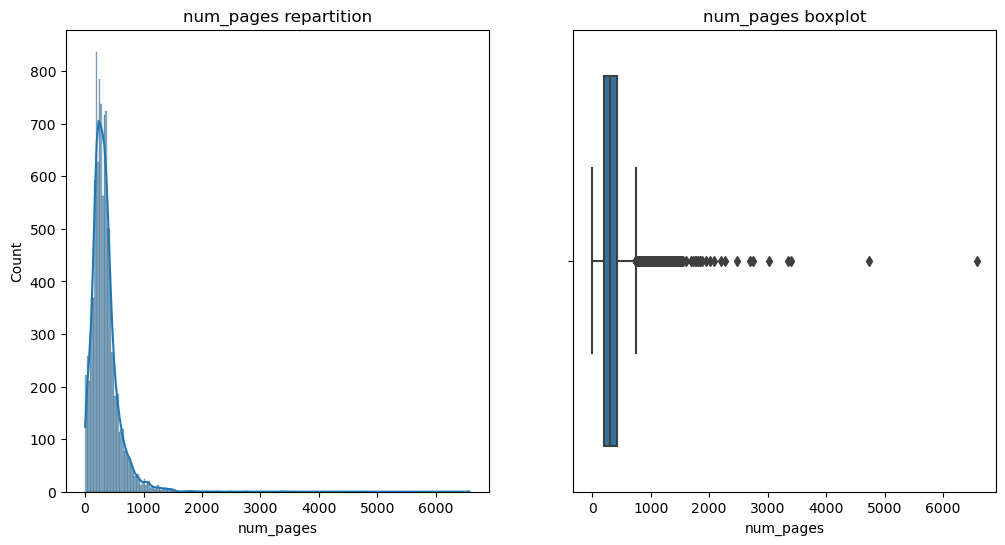

In [21]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs.flat[0].set_title('num_pages repartition')
sns.histplot(data=df, x='num_pages', bins=250, kde=True, ax=axs[0])
axs.flat[1].set_title('num_pages boxplot')
sns.boxplot(data=df, x='num_pages', ax=axs[1])

plt.show()

In [22]:
q1, q3 = df['num_pages'].quantile(0.25), df['num_pages'].quantile(0.75)
np_iqr = q3 - q1
np_low, np_up = q1 - (1.5 * np_iqr), q3 + (1.5 * np_iqr)
print(f"Lower outliers : {np_low}\nUpper outliers : {np_up}")

Lower outliers : -131.5
Upper outliers : 744.5


In [23]:
print(f"Num_pages total outliers : {df.loc[df['num_pages'] > np_up].shape[0]}")

Num_pages total outliers : 560


In [24]:
df = df.loc[df['num_pages'] <= np_up]

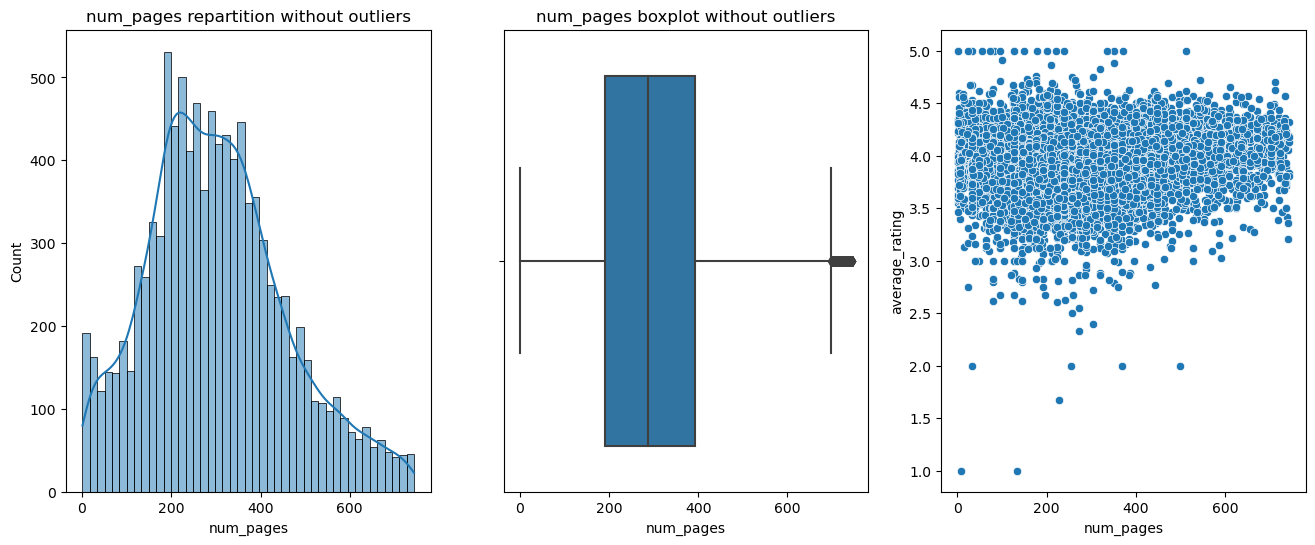

In [25]:
fig, axs = plt.subplots(1, 3, figsize=(16, 6))

axs.flat[0].set_title('num_pages repartition without outliers')
sns.histplot(data=df, x='num_pages', bins=45, kde=True, ax=axs[0])
axs.flat[1].set_title('num_pages boxplot without outliers')
sns.boxplot(data=df, x='num_pages', ax=axs[1])
sns.scatterplot(data=df, x='num_pages', y='average_rating', ax=axs[2])

plt.show()

<a id="2.2"></a>
## [2.2 Ratings count](#2.2)
[Sommaire](#0)

In [26]:
df['ratings_count'].describe()

count    1.040900e+04
mean     1.802015e+04
std      1.131543e+05
min      1.000000e+00
25%      1.110000e+02
50%      7.780000e+02
75%      5.067000e+03
max      4.597666e+06
Name: ratings_count, dtype: float64

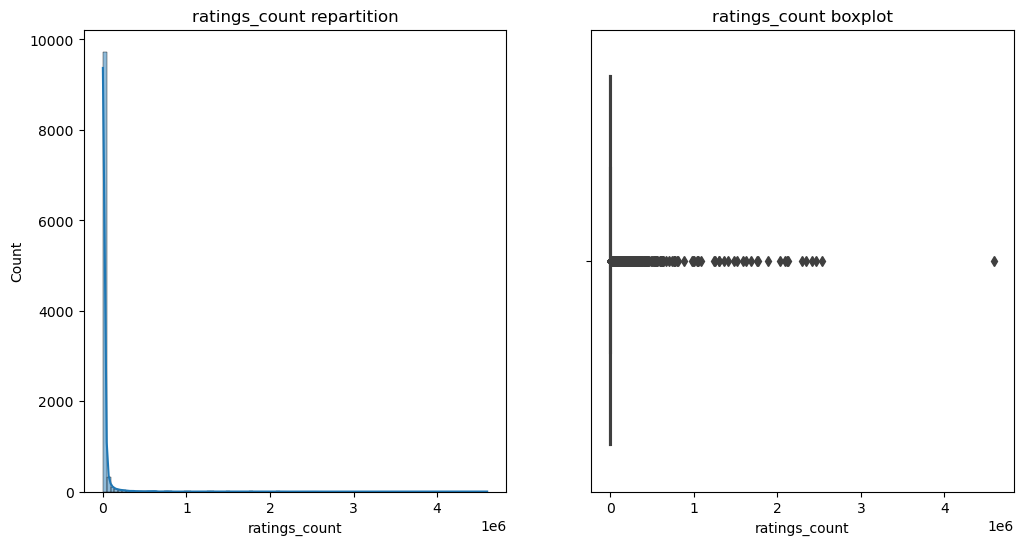

In [27]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs.flat[0].set_title('ratings_count repartition')
sns.histplot(data=df, x='ratings_count', bins=100, kde=True, ax=axs[0])
axs.flat[1].set_title('ratings_count boxplot')
sns.boxplot(data=df, x='ratings_count', ax=axs[1])

plt.show()

In [28]:
q1, q3 = df['ratings_count'].quantile(0.25), df['ratings_count'].quantile(0.75)
rc_iqr = q3 - q1
rc_low, rc_up = q1 - (1.5 * rc_iqr), q3 + (1.5 * rc_iqr)
print(f"Lower outliers : {rc_low}\nUpper outliers : {rc_up}")

Lower outliers : -7323.0
Upper outliers : 12501.0


In [29]:
print(f"Ratings_count total outliers : {df.loc[df['ratings_count'] > rc_up].shape[0]}")

Ratings_count total outliers : 1611


In [30]:
df = df.loc[df['ratings_count'] <= rc_up]
df.shape[0]

8798

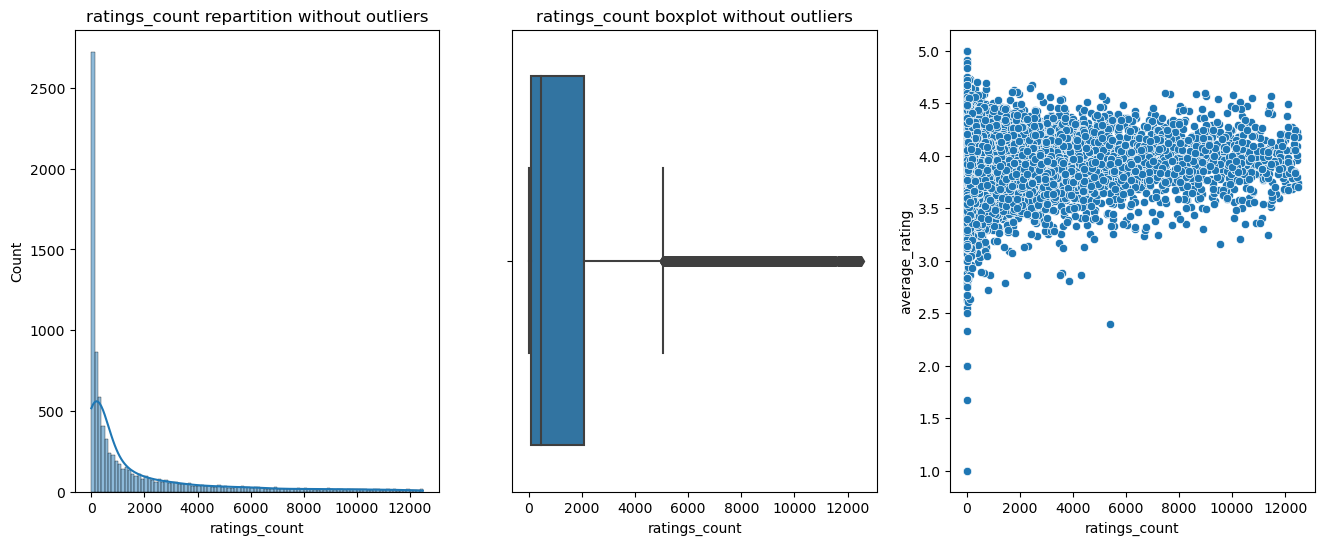

In [31]:
fig, axs = plt.subplots(1, 3, figsize=(16, 6))

axs.flat[0].set_title('ratings_count repartition without outliers')
sns.histplot(data=df, x='ratings_count', bins=100, kde=True, ax=axs[0])
axs.flat[1].set_title('ratings_count boxplot without outliers')
sns.boxplot(data=df, x='ratings_count', ax=axs[1])
sns.scatterplot(data=df, x='ratings_count', y='average_rating', ax=axs[2])

plt.show()

<a id="2.3"></a>
## [2.3 Test reviews count](#2.3)
[Sommaire](#0)

In [32]:
df['text_reviews_count'].describe()

count    8798.000000
mean       97.761878
std       166.660098
min         0.000000
25%         7.000000
50%        31.000000
75%       110.750000
max      1766.000000
Name: text_reviews_count, dtype: float64

In [33]:
print(df.loc[df['text_reviews_count'] == 0].shape)
df = df.loc[df['text_reviews_count'] > 0]

(516, 12)


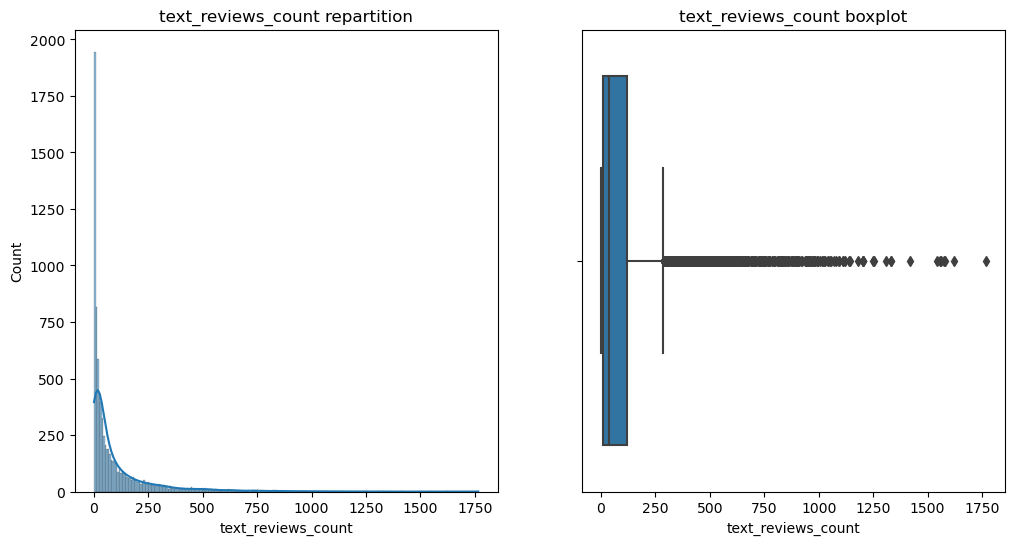

In [34]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs.flat[0].set_title('text_reviews_count repartition')
sns.histplot(data=df, x='text_reviews_count', bins=250, kde=True, ax=axs[0])
axs.flat[1].set_title('text_reviews_count boxplot')
sns.boxplot(data=df, x='text_reviews_count', ax=axs[1])

plt.show()

In [35]:
q1, q3 = df['text_reviews_count'].quantile(0.25), df['text_reviews_count'].quantile(0.75)
trc_iqr = q3 - q1
trc_low, trc_up = q1 - (1.5 * trc_iqr), q3 + (1.5 * trc_iqr)
print(f"Lower outliers : {trc_low}\nUpper outliers : {trc_up}")

Lower outliers : -157.5
Upper outliers : 286.5


In [36]:
print(f"text_reviews_count total outliers : {df.loc[df['text_reviews_count'] > trc_up].shape[0]}")

text_reviews_count total outliers : 851


In [37]:
df = df.loc[df['text_reviews_count'] <= trc_up]
print(f"Dataset rows : {df.shape[0]}")

Dataset rows : 7431


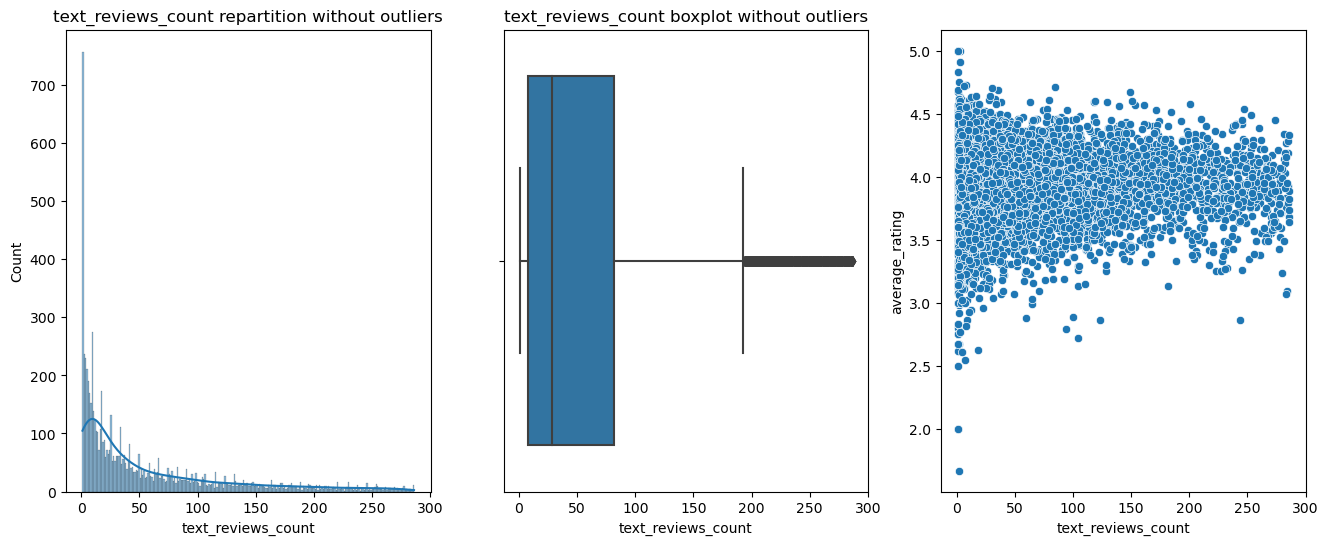

In [38]:
fig, axs = plt.subplots(1, 3, figsize=(16, 6))

axs.flat[0].set_title('text_reviews_count repartition without outliers')
sns.histplot(data=df, x='text_reviews_count', bins=250, kde=True, ax=axs[0])
axs.flat[1].set_title('text_reviews_count boxplot without outliers')
sns.boxplot(data=df, x='text_reviews_count', ax=axs[1])
sns.scatterplot(data=df, x='text_reviews_count', y='average_rating', ax=axs[2])

plt.show()

## Average rating

In [39]:
df['average_rating'].describe()

count    7431.000000
mean        3.927274
std         0.288166
min         1.670000
25%         3.760000
50%         3.940000
75%         4.120000
max         5.000000
Name: average_rating, dtype: float64

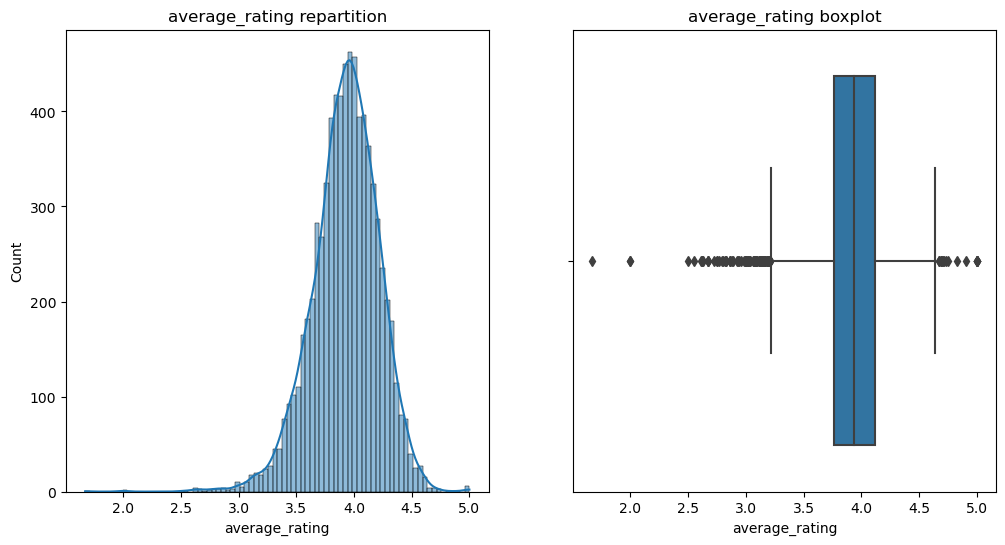

In [40]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs.flat[0].set_title('average_rating repartition')
sns.histplot(data=df, x='average_rating', bins=82, kde=True, ax=axs[0])
axs.flat[1].set_title('average_rating boxplot')
sns.boxplot(data=df, x='average_rating', ax=axs[1])

plt.show()

# TESTING

In [41]:
df_test = df.copy()

In [42]:
df_test['log_ratings_count'] = np.log(df_test['ratings_count'])

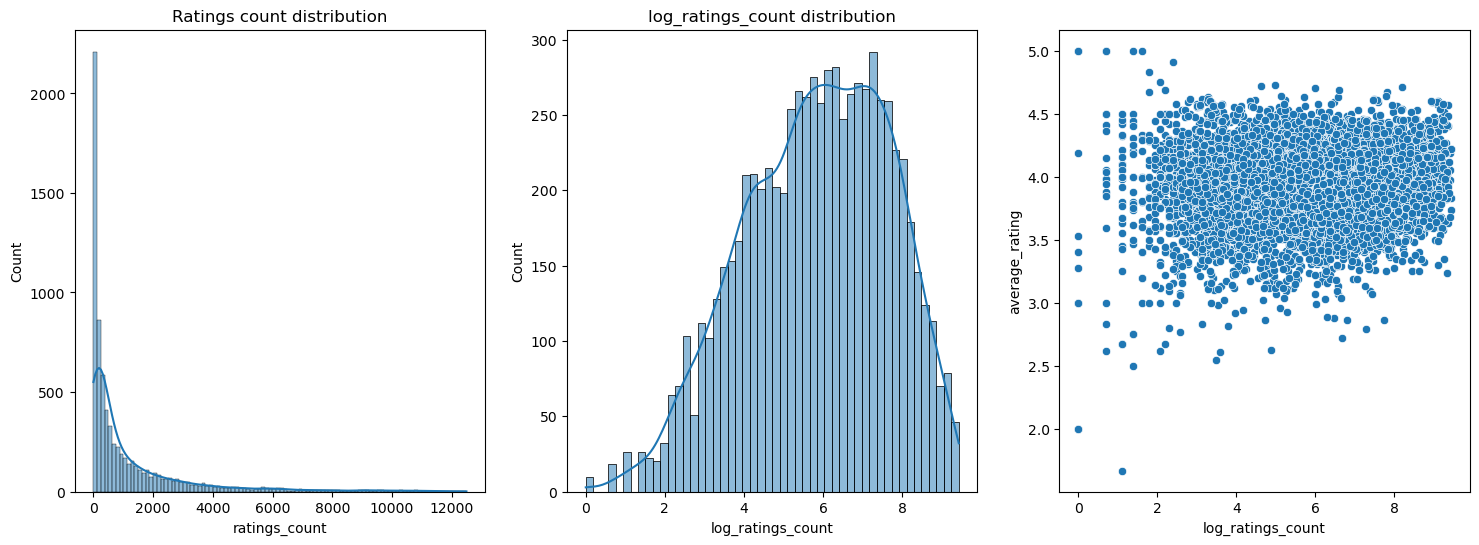

In [43]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

axs.flat[0].set_title('Ratings count distribution')
sns.histplot(data=df_test, x='ratings_count', kde=True, bins=100, ax=axs[0])
axs.flat[1].set_title('log_ratings_count distribution')
sns.histplot(data=df_test, x='log_ratings_count', kde=True, bins=50, ax=axs[1])
sns.scatterplot(data=df_test, x='log_ratings_count', y='average_rating', ax=axs[2])

plt.show()

In [44]:
df_test['log_text_reviews_count'] = np.log(df_test['text_reviews_count'])

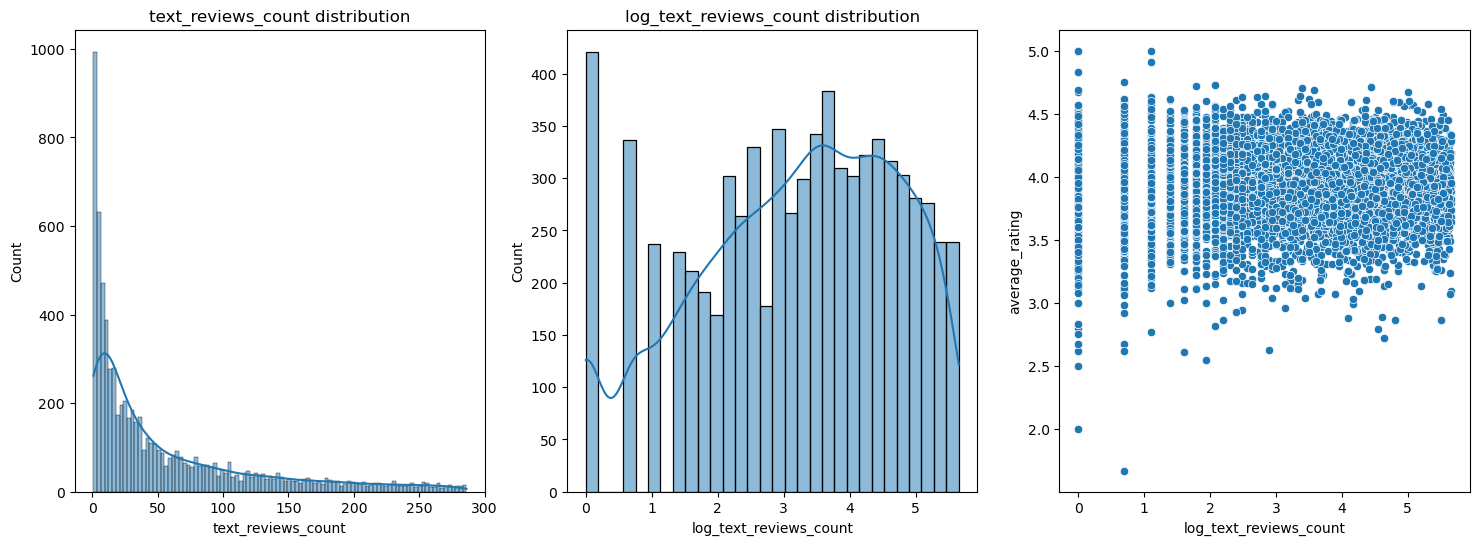

In [45]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

axs.flat[0].set_title('text_reviews_count distribution')
sns.histplot(data=df_test, x='text_reviews_count', kde=True, bins=100, ax=axs[0])
axs.flat[1].set_title('log_text_reviews_count distribution')
sns.histplot(data=df_test, x='log_text_reviews_count', kde=True, bins=30, ax=axs[1])
sns.scatterplot(data=df_test, x='log_text_reviews_count', y='average_rating', ax=axs[2])

plt.show()

In [46]:
df_test.corr(method='pearson')

C:\Users\albin\AppData\Local\Temp\ipykernel_304\1980075432.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_test.corr(method='pearson')


,bookID,average_rating,num_pages,ratings_count,text_reviews_count,log_ratings_count,log_text_reviews_count
bookID,1.000000,-0.046231,0.007253,-0.025136,-0.059960,-0.033640,-0.051547
average_rating,-0.046231,1.000000,0.081312,0.107144,0.009362,0.108114,0.030894
num_pages,0.007253,0.081312,1.000000,0.093372,0.076605,0.127253,0.095578
ratings_count,-0.025136,0.107144,0.093372,1.000000,0.709739,0.726749,0.603120
text_reviews_count,-0.059960,0.009362,0.076605,0.709739,1.000000,0.742192,0.820410
log_ratings_count,-0.033640,0.108114,0.127253,0.726749,0.742192,1.000000,0.906963
log_text_reviews_count,-0.051547,0.030894,0.095578,0.603120,0.820410,0.906963,1.000000


In [47]:
df['log_ratings_count'] = df_test['log_ratings_count']

<a id="2.4"></a>
## [2.4 Rating by reviews](#2.4)
[Sommaire](#0)

In [48]:
df_test['rating_by_reviews'] = df_test['ratings_count'] / df_test['text_reviews_count']

In [49]:
df_test['rating_by_reviews'].describe()

count    7431.000000
mean       20.467921
std        23.775170
min         1.000000
25%         8.500000
50%        13.500000
75%        23.273350
max       466.500000
Name: rating_by_reviews, dtype: float64

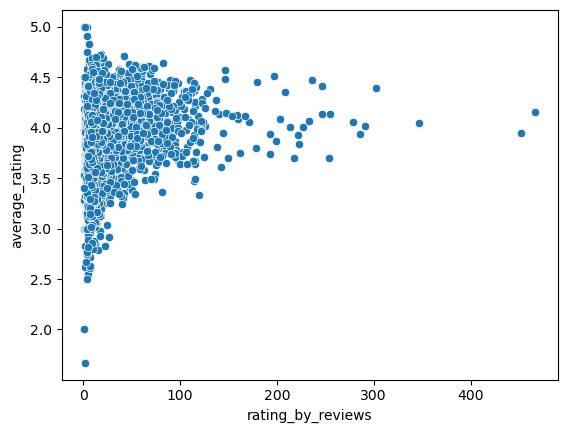

Pearson : 0.15827692913503344
Spearman : 0.17146658821398675


In [50]:
sns.scatterplot(data=df_test, x='rating_by_reviews', y='average_rating')
plt.show()
print(f"Pearson : {np.corrcoef(df_test['rating_by_reviews'], df['average_rating'])[0, 1]}")
print(f"Spearman : {stats.spearmanr(df_test['rating_by_reviews'], df_test['average_rating'])[0]}")

<a id="2.5"></a>
## [2.5 Reviews by ratings](#2.5)
[Sommaire](#0)

In [51]:
df_test['reviews_by_ratings'] = df_test['text_reviews_count'] / df_test['ratings_count']

In [52]:
df_test['reviews_by_ratings'].describe()

count    7431.000000
mean        0.091203
std         0.078364
min         0.002144
25%         0.042968
50%         0.074074
75%         0.117647
max         1.000000
Name: reviews_by_ratings, dtype: float64

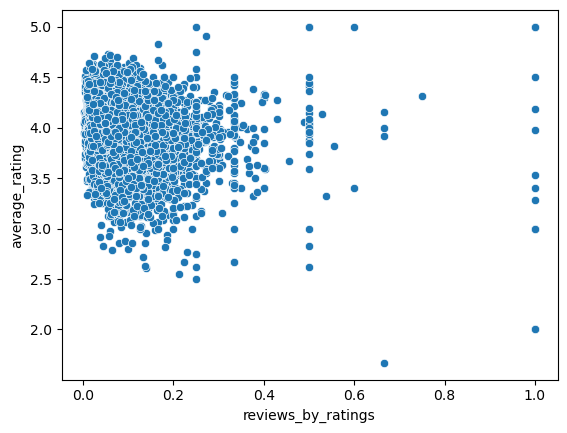

Pearson : -0.14738856605172007
Spearman : -0.17146658821398675


In [53]:
sns.scatterplot(data=df_test, x='reviews_by_ratings', y='average_rating')
plt.show()
print(f"Pearson : {np.corrcoef(df_test['reviews_by_ratings'], df['average_rating'])[0, 1]}")
print(f"Spearman : {stats.spearmanr(df_test['reviews_by_ratings'], df_test['average_rating'])[0]}")

<Axes: >

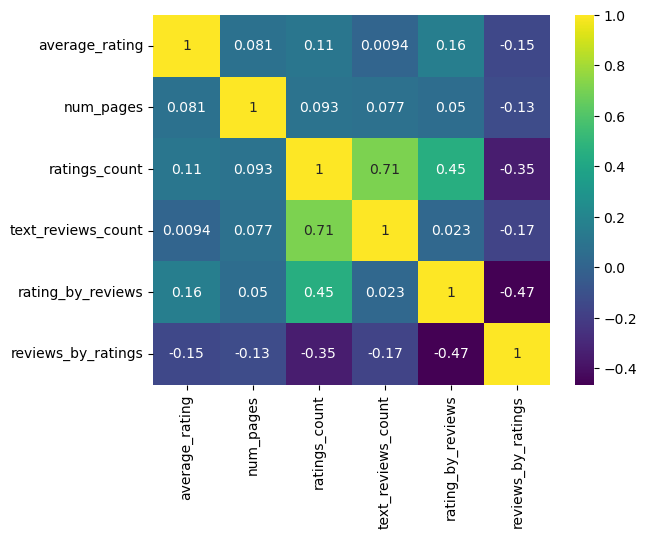

In [54]:
sns.heatmap(df_test[['average_rating', 'num_pages', 'ratings_count', 'text_reviews_count', 'rating_by_reviews', 'reviews_by_ratings']].corr(), annot=True, cmap='viridis')

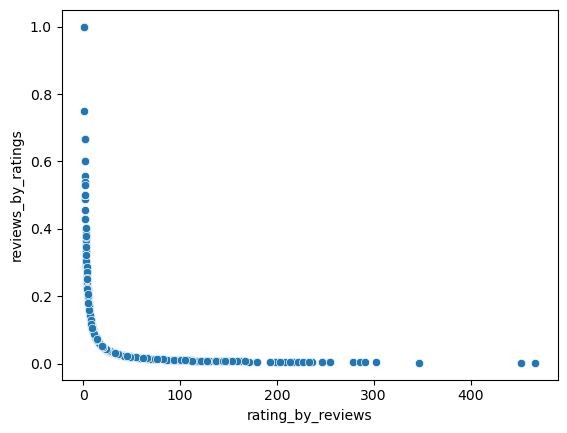

Spearman -1.0


In [55]:
sns.scatterplot(data=df_test, x='rating_by_reviews', y='reviews_by_ratings')
plt.show()
print(f"Spearman {stats.spearmanr(df_test['rating_by_reviews'], df_test['reviews_by_ratings'])[0]}")

In [56]:
df['rating_by_reviews'] = df_test['rating_by_reviews']
df['reviews_by_ratings'] = df_test['reviews_by_ratings']

In [57]:
df.columns.tolist(), df.shape[0]

(['bookID',
  'title',
  'authors',
  'average_rating',
  'isbn',
  'isbn13',
  'language_code',
  'num_pages',
  'ratings_count',
  'text_reviews_count',
  'publication_date',
  'publisher',
  'log_ratings_count',
  'rating_by_reviews',
  'reviews_by_ratings'],
 7431)

<a id="2.6"></a>
## [2.6 Publishers](#2.6)
[Sommaire](#0)

In order to see the number of books published by a unique publisher we create a new dataframe which contains the total number of published book, and also the average rating given by publisher

In [58]:
df_publi = df.groupby('publisher').agg({'title': 'count', 'average_rating': 'mean'}).sort_values(by='average_rating' ,ascending=False)
df_publi = df_publi.reset_index()
df_publi.sort_values(by='title')

,publisher,title,average_rating
0,University Press of New England,1,5.000000
1095,FASA Corp.,1,3.890000
1093,Denoël,1,3.890000
1089,Virago,1,3.890000
1088,FonoLibro,1,3.890000
...,...,...,...
1309,Ballantine Books,77,3.817273
868,Mariner Books,105,3.957905
947,Penguin Classics,118,3.932712
1050,Penguin Books,159,3.905031


<Axes: xlabel='title', ylabel='Count'>

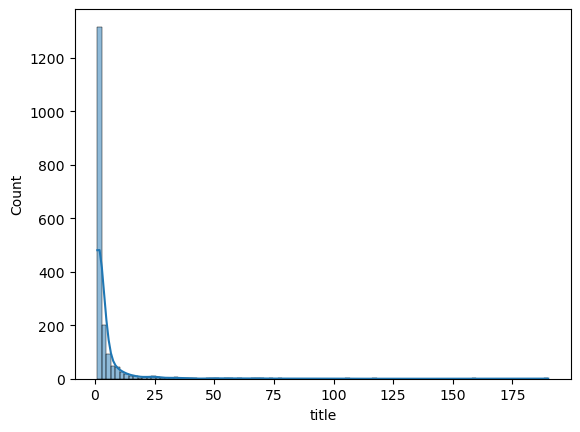

In [59]:
sns.histplot(data=df_publi, x='title', bins=100, kde=True)

In [60]:
df_publi['title'].describe()

count    1840.000000
mean        4.038587
std        10.002562
min         1.000000
25%         1.000000
50%         1.000000
75%         3.000000
max       190.000000
Name: title, dtype: float64

In the following section, we wanted to group unique publisher that has posted a certain amount of book.     
So we started by set a threshold to 1 book published and increased it until we find a distribution for both cases that was convenient.     
By setting the threshold to 3 we saw that we have two gaussian-like distribution

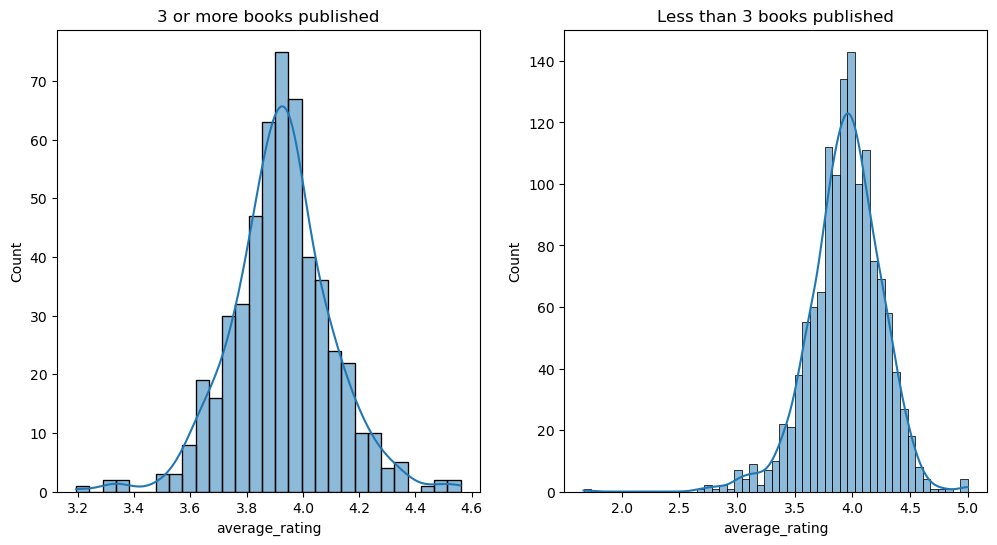

In [61]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs.flat[0].set_title('3 or more books published')
sns.histplot(df_publi.loc[df_publi['title'] >= 3, 'average_rating'], kde=True, ax=axs[0])
axs.flat[1].set_title('Less than 3 books published')
sns.histplot(df_publi.loc[df_publi['title'] < 3, 'average_rating'], kde=True, ax=axs[1])
plt.show()

The following graph shows a comparison between the choosen splitter for the publisher vs a normal distribution (red line)
* Below 3.5 it gets messy
* Above 4.4 also

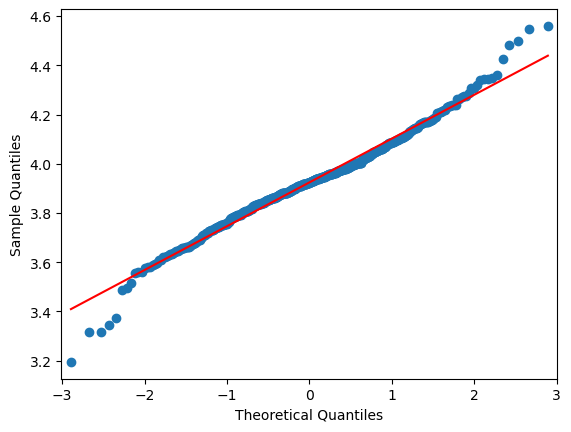

In [62]:
sm.qqplot(df_publi.loc[df_publi['title'] >= 3, 'average_rating'], line='s')
plt.show()

We have 1316 publishers that have published **less than** 3 books, and 524 publishers that have published **at least** 3 books.

In [63]:
print(df_publi.loc[df_publi['title'] < 3, 'title'].cumsum()), print('-'*100), print(df_publi.loc[df_publi['title'] >= 3, 'title'].cumsum())

0          1
1          2
2          3
3          4
4          5
        ... 
1835    1591
1836    1592
1837    1594
1838    1595
1839    1596
Name: title, Length: 1316, dtype: int64
----------------------------------------------------------------------------------------------------
18         3
20         8
28        11
38        24
64        27
        ... 
1786    5821
1792    5824
1797    5828
1798    5831
1810    5835
Name: title, Length: 524, dtype: int64


(None, None, None)

Next, for publishers with **less than** 3 books, we assigned them a *factor* to 0.    
And to the others, we assigned them a *factor* that correspond to the ith element encoutered in the loop.    
Like that, we have all the publishers with less than 3 book considered as one publisher, and the other one have their own treatment

In [64]:
""" Create the group of publisher that have published less than 3 books
    And setting to this group a factor value of 0
    Then the other on will have a factor value whose correspond to the
    ith new encoutered element """
i = 1
for n in range(df_publi.shape[0]):
    if df_publi['publisher'].iloc[n] in df_publi.loc[df_publi['title'] < 3, 'publisher'].values.tolist():
        df_publi.loc[n, 'factor'] = 0
    else:
        df_publi.loc[n, 'factor'] = i
        i += 1

In [65]:
""" Mapping the factor value created above to the whole dataset """
df = df.reset_index().drop(columns=['index'])
for n in range(df.shape[0]):
    df.loc[n, 'factor'] = df_publi.loc[df_publi['publisher'] == df.loc[n, 'publisher'], 'factor'].values[0]

In [66]:
print(f"Unique factor created : {df_publi['factor'].nunique()}")
print(f"Unique factor in the whole dataset : {df['factor'].nunique()}")

Unique factor created : 525
Unique factor in the whole dataset : 525


In the following plot, we can see that there is a negative correlation between the average rating and the *factor* created above

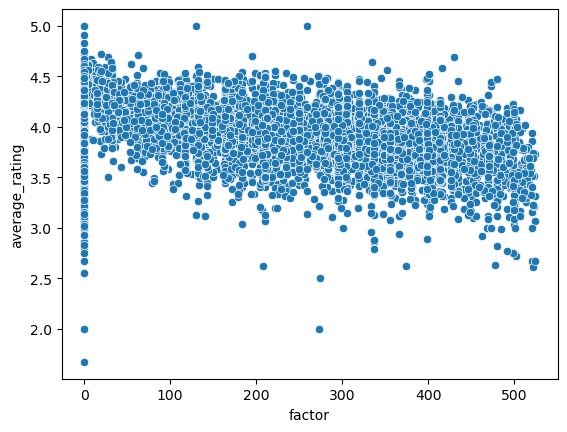

Pearson : -0.29639072733421185
Spearman : -0.29106505548671185


In [67]:
sns.scatterplot(data=df, x='factor', y='average_rating')
plt.show()
print(f"Pearson : {np.corrcoef(df['factor'], df['average_rating'])[0, 1]}")
print(f"Spearman : {stats.spearmanr(df['factor'], df['average_rating'])[0]}")

In [68]:
df.columns.tolist()

['bookID',
 'title',
 'authors',
 'average_rating',
 'isbn',
 'isbn13',
 'language_code',
 'num_pages',
 'ratings_count',
 'text_reviews_count',
 'publication_date',
 'publisher',
 'log_ratings_count',
 'rating_by_reviews',
 'reviews_by_ratings',
 'factor']

<a id="2.7"></a>
## [2.7 publication_date](#2.7)
[Sommaire](#0)

In [69]:
df['month'] = df['publication_date'].dt.month

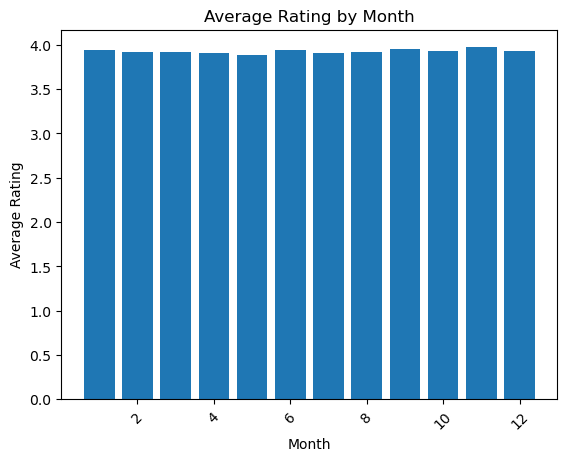

In [70]:
# Is there a correlation on the month of the publication ? 

df_month = df.groupby('month').agg({'title': 'count', 'average_rating': 'mean'}).sort_values(by='average_rating' ,ascending=False)

month = df_month.index
average_ratings = df_month['average_rating']

# Create the bar plot
plt.bar(month, average_ratings)

# Set labels and title
plt.xlabel('Month')
plt.ylabel('Average Rating')
plt.title('Average Rating by Month')
plt.xticks(rotation=45)

# Show the plot
plt.show()

# We got almost the same value every month, no need to keep this idea

In [71]:
# And what if we cut the Year by season ? 

df_test_season = df.copy()
df_test_season["Season"] = ["Summer" if x in [6,7,8] else "Autaumn" if x in [9,10,11] else "Winter" if x in [12, 1, 2] else "Spring" for x in df_test_season["month"]]

df_season = df_test_season.groupby('Season').agg({'title': 'count', 'average_rating': 'mean'}).sort_values(by='average_rating' ,ascending=False)
display(df_season)

# Same Answer, same value of average rating for every season, we let this idea away 

,title,average_rating
Season,,
Autaumn,2240,3.948687
Winter,1726,3.928783
Summer,1661,3.921951
Spring,1804,3.904141


In [72]:
df_test['year'] = df_test['publication_date'].dt.year
df['year'] = df['publication_date'].dt.year
df['year'].describe()

count    7431.000000
mean     1999.702597
std         8.701253
min      1900.000000
25%      1997.000000
50%      2002.000000
75%      2005.000000
max      2019.000000
Name: year, dtype: float64

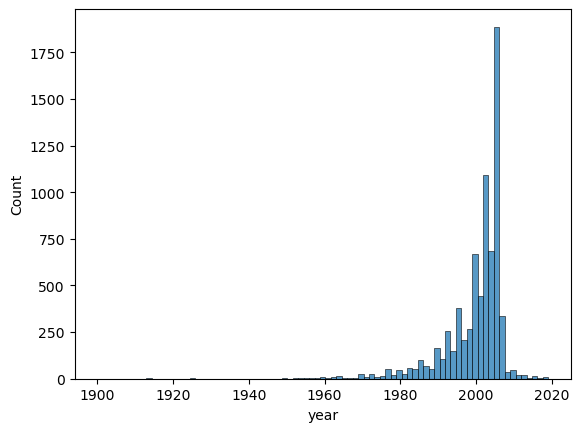

In [73]:
nb_years = len(df['year'].unique())

sns.histplot(df['year'], bins=nb_years)
plt.show()

Decile of the number of books published in one year

In [74]:
for i in range(0, 10):
    print(f"{i*10}-{(i+1)*10}% : {df.groupby('year')['average_rating'].count().quantile((i+1)/10)}")

0-10% : 1.0
10-20% : 2.0
20-30% : 4.0
30-40% : 5.0
40-50% : 11.0
50-60% : 22.0
60-70% : 30.999999999999993
70-80% : 97.20000000000014
80-90% : 291.3999999999999
90-100% : 1084.0


In [75]:
df_yr = df.groupby('year')['average_rating'].agg(['count', 'min', 'max', 'mean', 'median', 'std'])

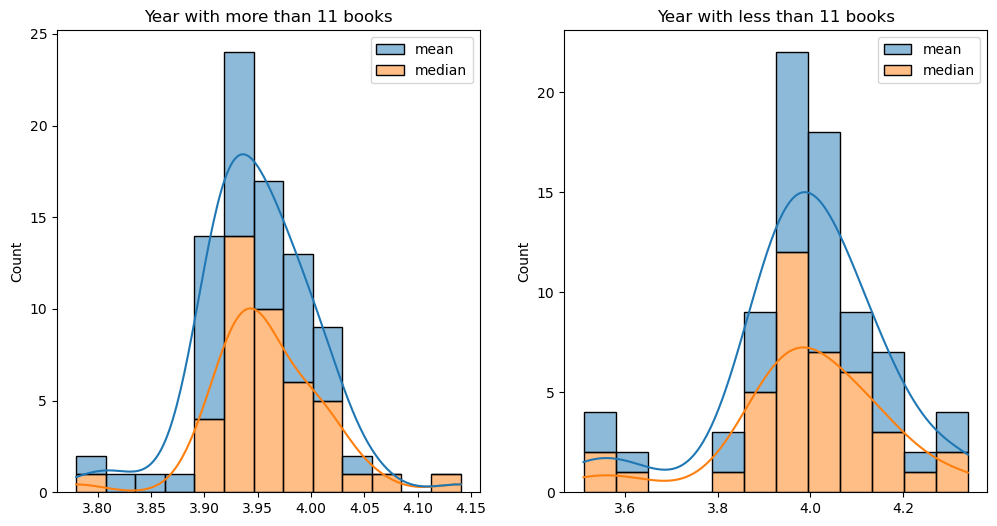

ANOVA p-value : 0.07356267454290413


In [76]:
threshold = 11
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs.flat[0].set_title(f'Year with more than {threshold} books')
sns.histplot(df_yr.loc[df_yr['count'] >= threshold, ['mean', 'median']], kde=True, multiple='stack', ax=axs[0])
axs.flat[1].set_title(f'Year with less than {threshold} books')
sns.histplot(df_yr.loc[df_yr['count'] < threshold, ['mean', 'median']], kde=True, multiple='stack', ax=axs[1])

plt.show()
print(f"ANOVA p-value : {stats.f_oneway(df_yr.loc[df_yr['count'] >= threshold, 'mean'], df_yr.loc[df_yr['count'] < threshold, 'mean'])[1]}")


Dict composed of :
- As keys : A threshold to separate years according to numbers of book published during this year
- As values : ANOVA p-value

We can see that there isn't a threshold for which there is a significant difference in group means

In [77]:
anova_dict = {}
for i in range(2, 22):
    anova_dict[i] = stats.f_oneway(df_yr.loc[df_yr['count'] >= i, 'mean'], df_yr.loc[df_yr['count'] < i, 'mean'])[1]
    
anova_dict

{2: 0.7403141239563689,
 3: 0.7225017607189156,
 4: 0.38078839581379875,
 5: 0.20643326610952348,
 6: 0.07645346747210478,
 7: 0.11792966649008638,
 8: 0.145952035507281,
 9: 0.08865931358548489,
 10: 0.08564618416174109,
 11: 0.07356267454290413,
 12: 0.13648331905890898,
 13: 0.1588124407221372,
 14: 0.1474254579938279,
 15: 0.2428643064441606,
 16: 0.2428643064441606,
 17: 0.2428643064441606,
 18: 0.2428643064441606,
 19: 0.28620886009484514,
 20: 0.28620886009484514,
 21: 0.28620886009484514}

The idea here is to retrieve years in decile, based on the average rating during the year    

In [78]:
print(df_yr.loc[df_yr['count'] >= 10, 'count'].cumsum().values[-1])
print(df.shape[0])
print(f"Nb of line loss : {df.shape[0] - df_yr.loc[df_yr['count'] >= 10, 'count'].cumsum().values[-1]}")

7308
7431
Nb of line loss : 123


In [79]:
dfy10 = df_yr.loc[df_yr['count'] >= 10]
dfy10.sort_values(by='mean')

,count,min,max,mean,median,std
year,,,,,,
1964,14,3.12,4.37,3.805000,3.780,0.358174
2012,11,2.83,4.43,3.818182,3.930,0.409630
1972,11,3.46,4.20,3.854545,3.900,0.277718
1976,23,3.33,4.22,3.886957,3.920,0.249061
1999,297,2.80,4.64,3.892862,3.900,0.250604
1987,68,3.25,4.43,3.895588,3.925,0.278361
1994,150,2.61,4.54,3.900400,3.915,0.300167
2007,334,2.89,5.00,3.903234,3.920,0.307739
2009,27,3.17,4.40,3.903333,4.040,0.311065


In [80]:
q1 = dfy10['mean'].quantile(0.25)
q2 = dfy10['mean'].quantile(0.5)
q3 = dfy10['mean'].quantile(0.75)
print('Mean quantile')
print(q1)
print(q2)
print(q3)
print('-'*100)
print('Median quantile')
print(dfy10['median'].quantile(0.25))
print(dfy10['median'].quantile(0.5))
print(dfy10['median'].quantile(0.75))

Mean quantile
3.909089725167698
3.9332056246330387
3.9785314685314686
----------------------------------------------------------------------------------------------------
Median quantile
3.93
3.9525
3.99625


In [81]:
year_q1 = dfy10.loc[dfy10['mean'] <= q1]
year_q2 = dfy10.loc[(dfy10['mean'] > q1) & (dfy10['mean'] <= q2)]
year_q3 = dfy10.loc[(dfy10['mean'] > q2) & (dfy10['mean'] <= q3)]
year_q4 = dfy10.loc[dfy10['mean'] > q3]

<Axes: ylabel='Count'>

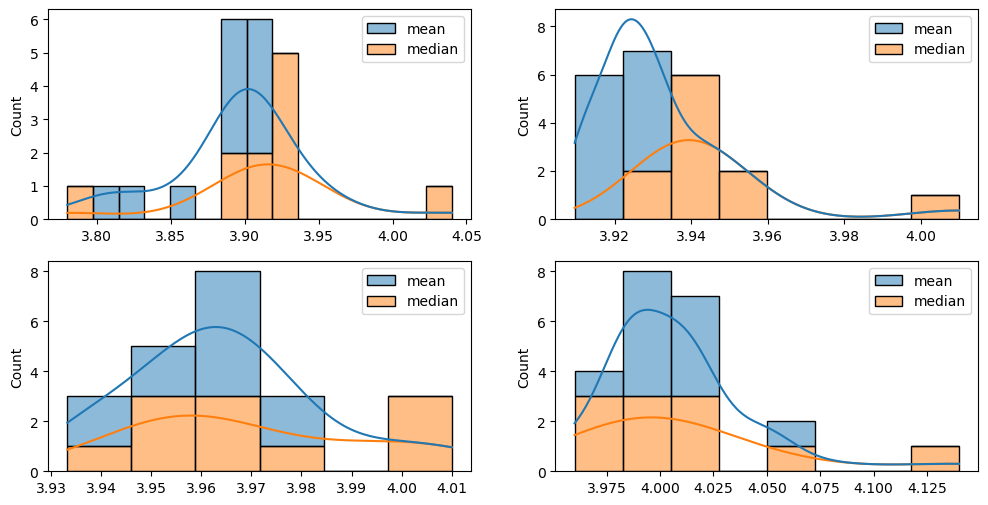

In [82]:
fig, axs = plt.subplots(2, 2, figsize=(12, 6))

sns.histplot(year_q1[['mean', 'median']], kde=True, multiple='stack', ax=axs[0, 0])
sns.histplot(year_q2[['mean', 'median']], kde=True, multiple='stack', ax=axs[0, 1])
sns.histplot(year_q3[['mean', 'median']], kde=True, multiple='stack', ax=axs[1, 0])
sns.histplot(year_q4[['mean', 'median']], kde=True, multiple='stack', ax=axs[1, 1])

In [83]:
year_q1['count'].cumsum()

year
1964      14
1972      25
1976      48
1987     116
1994     266
1998     535
1999     832
2007    1166
2009    1193
2011    1211
2012    1222
Name: count, dtype: int64

We performed an ANOVA to see if there is a difference in those groups means.    
As the p-value is inferior to 0.05, there is a significant difference.

In [84]:
stats.f_oneway(year_q1['mean'], year_q2['mean'], year_q3['mean'], year_q4['mean'])

F_onewayResult(statistic=61.72100259666676, pvalue=4.591818895656413e-15)

In [85]:
df_test['year_q1'] = 0
for years in year_q1.index:
    df_test['year_q1'] = np.where(df_test['year'] == years, 1, df_test['year_q1'])

df_test['year_q2'] = 0
for years in year_q2.index:
    df_test['year_q2'] = np.where(df_test['year'] == years, 1, df_test['year_q2'])

df_test['year_q3'] = 0
for years in year_q3.index:
    df_test['year_q3'] = np.where(df_test['year'] == years, 1, df_test['year_q3'])

df_test['year_q4'] = 0
for years in year_q4.index:
    df_test['year_q4'] = np.where(df_test['year'] == years, 1, df_test['year_q4'])

<Axes: >

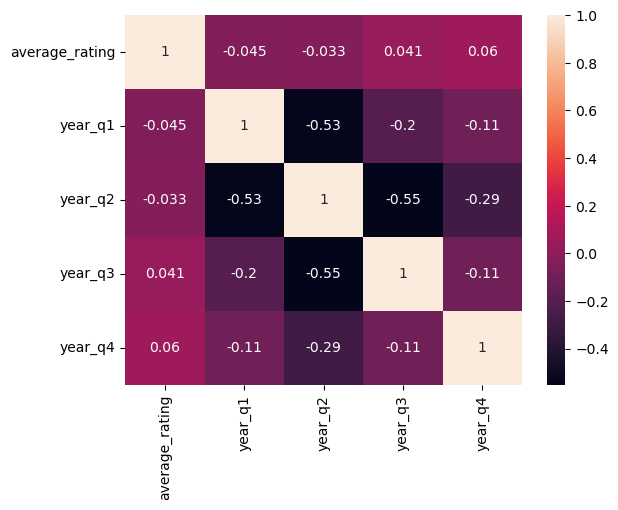

In [86]:
sns.heatmap(df_test[['average_rating', 'year_q1', 'year_q2', 'year_q3', 'year_q4']].corr(), annot=True)

In [87]:
df['year_q1'] = 0
for years in year_q1.index:
    df['year_q1'] = np.where(df['year'] == years, 1, df['year_q1'])

df['year_q2'] = 0
for years in year_q2.index:
    df['year_q2'] = np.where(df['year'] == years, 1, df['year_q2'])

df['year_q3'] = 0
for years in year_q3.index:
    df['year_q3'] = np.where(df['year'] == years, 1, df['year_q3'])

df['year_q4'] = 0
for years in year_q4.index:
    df['year_q4'] = np.where(df['year'] == years, 1, df['year_q4'])

In [88]:
rating_quantile = []
for i in range(0, 10):
    if i == 9:
        print(f"90-99% : < {df['average_rating'].quantile(0.99)}")
        print(f"99-100% : < {df['average_rating'].quantile(1)}")
        break
    print(f"{i*10}-{(i+1)*10}% : < {df['average_rating'].quantile((i+1)/10)}")
    rating_quantile.append(df['average_rating'].quantile((i+1)/10))

0-10% : < 3.56
10-20% : < 3.71
20-30% : < 3.8
30-40% : < 3.88
40-50% : < 3.94
50-60% : < 4.01
60-70% : < 4.08
70-80% : < 4.16
80-90% : < 4.27
90-99% : < 4.53
99-100% : < 5.0


In [89]:
rating_quantile

[3.56, 3.71, 3.8, 3.88, 3.94, 4.01, 4.08, 4.16, 4.27]

<a id="2.8"></a>
## [2.8 Adapting *authors*](#2.8)
[Sommaire](#0)

First problem, the ***authors*** columns contains 5093 unique values

In [90]:
df['authors'].describe()

count                 7431
unique                5093
top       Rumiko Takahashi
freq                    30
Name: authors, dtype: object

Below, we can see that if there is that much unique values, it's because authors columns contains string values, and one string can contain multiple authors that are separated by **/**

In [91]:
all_authors = df['authors'].tolist()
print(all_authors[:5])
print(len(all_authors))

['J.K. Rowling', 'W. Frederick Zimmerman', 'Douglas Adams/Stephen Fry', 'Bill Bryson', 'Jude Fisher']
7431


We create an author dict that will contains as key the author name, and as value the number of occurence of this author in the whole dataset

In [92]:
author_dict = {}
for authors in all_authors:
    authors_list = authors.split('/')
    for author in authors_list:
        if author not in author_dict:
            author_dict[author] = 1
        else:
            author_dict[author] += 1

In [93]:
d = {"Author_name": list(author_dict.keys()), "count": list(author_dict.values())}

In [94]:
author_df = pd.DataFrame(data=d)

The author threshold is set to 15 because we thought that a model can generalize on one author based on 15 differents books and ratings 

In [95]:
aut_tresh = 15
author_df.loc[author_df['count'] >= aut_tresh].sort_values(by='count', ascending=False)

,Author_name,count
308,William Shakespeare,74
1055,Stephen King,60
5177,Sandra Brown,39
2991,P.G. Wodehouse,36
517,J.R.R. Tolkien,36
2619,Mercedes Lackey,33
4004,Rumiko Takahashi,30
2858,Piers Anthony,28
1623,Dick Francis,28
1054,Margaret Weis,27


Creating a dataframe that contains all authors with more than 15 books published.    
The name doesn't stand for top as best authors but top as more published book.

In [96]:
top_authors = author_df.loc[author_df['count'] >= aut_tresh, 'Author_name'].unique()
top_authors

array(['Gabriel García Márquez', 'Hiromu Arakawa', 'Plato', 'Homer',
       'Richmond Lattimore', 'William Shakespeare', 'Euripides',
       'Sophocles', 'Aristophanes', 'Jane Austen', 'Charles Dickens',
       'J.R.R. Tolkien', 'Christopher Tolkien', 'Herman Melville',
       'Mark Twain', 'Gordon Korman', 'Christopher Hitchens',
       'Ray Bradbury', 'Fyodor Dostoyevsky', 'Dave Eggers',
       'Kurt Vonnegut Jr.', 'Margaret Weis', 'Stephen King', 'Roald Dahl',
       'James Patterson', 'Orson Scott Card', 'Laura Ingalls Wilder',
       'Dick Francis', 'Francine Pascal', 'C.S. Lewis',
       'Joyce Carol Oates', 'Albert Camus', 'Noam Chomsky', 'Tom Clancy',
       'Hirohiko Araki', 'CLAMP', 'Yumi Hotta', 'Mercedes Lackey',
       'Virginia Woolf', 'Piers Anthony', 'Dante Alighieri',
       'Agatha Christie', 'P.G. Wodehouse', 'Alan Dean Foster',
       'Grant Morrison', 'Rumiko Takahashi', 'Tracy Hickman',
       'Jack Vance', 'Sandra Brown'], dtype=object)

In [97]:
top_aut_anova = {}

In [98]:
df_test['authors']

2                                             J.K. Rowling
5                                   W. Frederick Zimmerman
10                               Douglas Adams/Stephen Fry
14                                             Bill Bryson
26                                             Jude Fisher
                               ...                        
11039    William T. Vollmann/Larry McCaffery/Michael He...
11040                                  William T. Vollmann
11041                                  William T. Vollmann
11042                                  William T. Vollmann
11043                                           Mark Twain
Name: authors, Length: 7431, dtype: object

Here, we create a column with the name of each actor in the top_authors list.    
We assign the value of 0 when the authors columns does not contains the author's name, 1 otherwise.    
Then we perform an ANOVA between the author's average rating on whom we are on the loop, and all the other author's average rating.

In [99]:
for aut in top_authors:
    df_test[aut] = 0
    df_test[aut] = np.where(df_test['authors'].str.contains(aut), 1, df_test[aut])

    anov = stats.f_oneway(df_test.loc[df_test[aut] == 0, 'average_rating'], df_test.loc[df_test[aut] == 1, 'average_rating'])[1]
    if aut not in top_aut_anova:
        top_aut_anova[aut] = anov


We create a dataframe that will contains :
- the authors names
- the associated ANOVA p-value.

In [100]:
aut_analys_df = pd.DataFrame()

In [101]:
aut_analys_df['authors'] = top_aut_anova.keys()

In [102]:
aut_analys_df['p_value'] = top_aut_anova.values()

Then we compute the pearson correlation coefficient between the author and the average rating, our interest variable. 

In [103]:
for aut in aut_analys_df['authors']:
    aut_analys_df.loc[aut_analys_df['authors'] == aut, 'pearson'] = np.corrcoef(df_test[aut], df_test['average_rating'])[0, 1]

And then we select only the authors whose average rating are statistically different from the others, thanks to the p-value.

In [104]:
aut_analys_df.loc[aut_analys_df['p_value'] < 0.05].sort_values(by='pearson')

,authors,p_value,pearson
48,Sandra Brown,1.040030e-08,-0.066340
28,Francine Pascal,1.413646e-05,-0.050343
39,Piers Anthony,2.343706e-05,-0.049041
13,Herman Melville,3.021226e-05,-0.048375
25,Orson Scott Card,2.756794e-04,-0.042181
21,Margaret Weis,5.413871e-03,-0.032262
30,Joyce Carol Oates,7.531808e-03,-0.030999
43,Alan Dean Foster,1.543064e-02,-0.028097
22,Stephen King,2.327533e-02,0.026320
9,Jane Austen,1.661591e-02,0.027784


We create two dataframes :
- top author : Contains all the authors whose average rating are statistically different from the others, and who are positively correlated with our interest variable.
- bad author : Same as top author, but that are negatively correlated.

In [105]:
top_authors = aut_analys_df.loc[(aut_analys_df['p_value'] < 0.05) & (aut_analys_df['pearson'] > 0), ['authors', 'pearson']]
bad_authors = aut_analys_df.loc[(aut_analys_df['p_value'] < 0.05) & (aut_analys_df['pearson'] < 0), ['authors', 'pearson']]

In [106]:
df_test['top_author'] = 0
for aut in top_authors['authors']:
    df_test['top_author'] = np.where(df_test['authors'].str.contains(aut), 1, df_test['top_author'])

df_test['bad_author'] = 0
for aut in bad_authors['authors']:
    df_test['bad_author'] = np.where(df_test['authors'].str.contains(aut), 1, df_test['bad_author'])

In [107]:
df_test['top_author'].value_counts()

0    7034
1     397
Name: top_author, dtype: int64

In [108]:
df['top_author'] = 0
for aut in top_authors['authors']:
    df['top_author'] = np.where(df['authors'].str.contains(aut), 1, df['top_author'])

df['bad_author'] = 0
for aut in bad_authors['authors']:
    df['bad_author'] = np.where(df['authors'].str.contains(aut), 1, df['bad_author'])

In [109]:
df.columns.tolist()

['bookID',
 'title',
 'authors',
 'average_rating',
 'isbn',
 'isbn13',
 'language_code',
 'num_pages',
 'ratings_count',
 'text_reviews_count',
 'publication_date',
 'publisher',
 'log_ratings_count',
 'rating_by_reviews',
 'reviews_by_ratings',
 'factor',
 'month',
 'year',
 'year_q1',
 'year_q2',
 'year_q3',
 'year_q4',
 'top_author',
 'bad_author']

C:\Users\albin\AppData\Local\Temp\ipykernel_304\956792719.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=True)


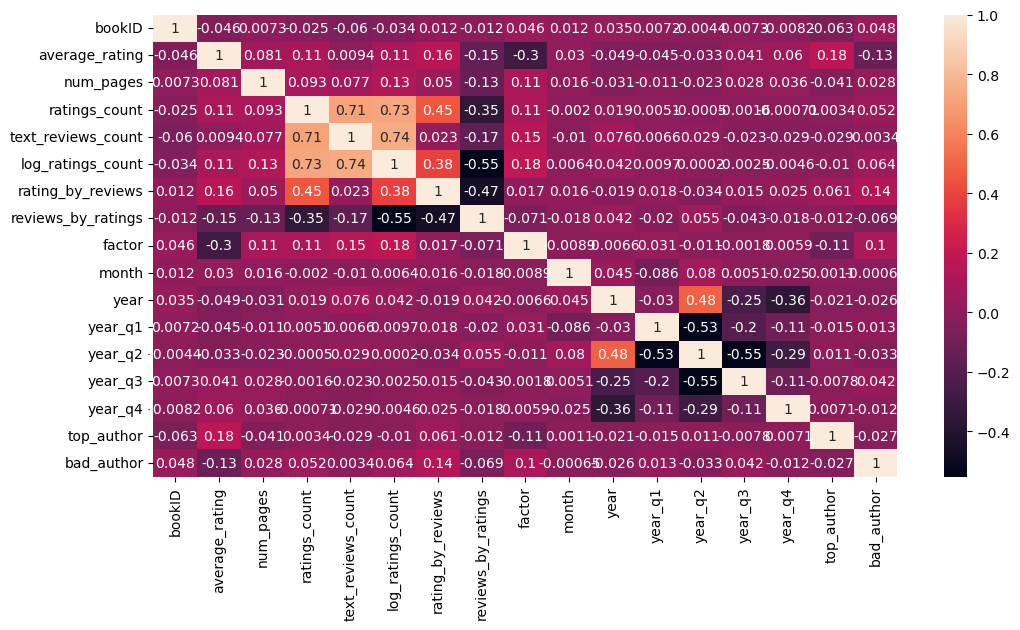

In [110]:
plt.figure(figsize=(12,6))
sns.heatmap(df.corr(), annot=True)
plt.show()

In [111]:
features_corr = ['num_pages', 'ratings_count', 'text_reviews_count','rating_by_reviews', 'reviews_by_ratings', 'factor',
                'year', 'top_author', 'bad_author', 'year_q1', 'year_q2', 'year_q3', 'year_q4']
dependent = ['average_rating']

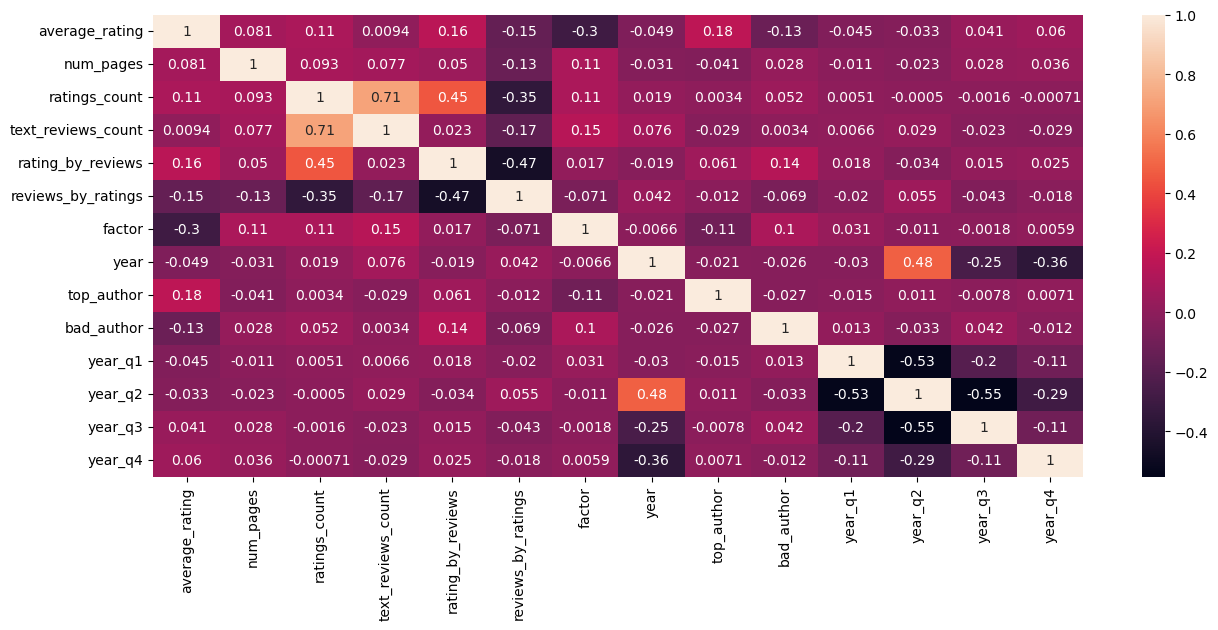

In [112]:
plt.figure(figsize=(15, 6))
sns.heatmap(df[dependent+features_corr].corr(), annot=True)
plt.show()

In [113]:
# Encoding  authors
"""
We will now try to encode string authors like this : 
We will encode into an hash every word of the string into a number so that if a same name 
is found in a string, we will have the same number and will group them together.
n_buckets will be the number of buckets we will use to group the words. If set to 10 we will create 10 group of string
and the full name of the author will result as a linear combinaison of 10 columns
""" 

import hashlib

def hashing_words(string, n_buckets):
    hashed_words = []
    words = string.split()

    for word in words:
        hashed_word = int(hashlib.md5(word.encode()).hexdigest(), 16) % n_buckets  #Keep digit from 0 to nb_bucket-1
        hashed_words.append(hashed_word)
    return hashed_words

n_buckets= 11

df['Author_Encoded'] = df['authors'].apply(lambda x: hashing_words(x, n_buckets))

display(df[['authors','Author_Encoded']].head(10))

,authors,Author_Encoded
0,J.K. Rowling,"[5, 3]"
1,W. Frederick Zimmerman,"[10, 7, 9]"
2,Douglas Adams/Stephen Fry,"[1, 3, 5]"
3,Bill Bryson,"[5, 3]"
4,Jude Fisher,"[10, 5]"
5,Dave Thomas/David Heinemeier Hansson/Leon Bree...,"[7, 8, 3, 6, 4, 4, 10, 9]"
6,Donna Ickes/Edward Sciranko/Keith Vasconcelles,"[8, 8, 7, 1]"
7,Dale Peck,"[7, 8]"
8,Angela Knight/Sahara Kelly/Judy Mays/Marteeka ...,"[0, 3, 3, 8, 7, 6, 8, 7, 9, 3]"
9,Delia Sherman,"[3, 6]"


In [114]:
# Now To encode into columns 

# First we will only keep unique values of each number 
df['Author_Encoded'] = df['Author_Encoded'].apply(lambda x: np.unique(x))

# Then we will split every number into a column 
# One hot encoding on the columns encoded

one_hot_encoded_author = pd.get_dummies(df['Author_Encoded'].apply(pd.Series).stack()).sum(level=0)

# Rename the one-hot encoded columns with "Title__Encoded_1", "Title_Encoded_2", ...
one_hot_encoded_author.columns = ['Author_Encoded_' + str(int(col)) for col in one_hot_encoded_author.columns]

# Concatenate the one-hot encoded columns to the original DataFrame 
df = pd.concat([df, one_hot_encoded_author], axis=1)

display(df[['authors','Author_Encoded', 'Author_Encoded_0', 'Author_Encoded_1', 'Author_Encoded_2', 'Author_Encoded_3', 'Author_Encoded_4', 'Author_Encoded_5', 'average_rating']].head(10))

# Dropping previous column
df.drop('Author_Encoded', axis=1, inplace=True)

C:\Users\albin\AppData\Local\Temp\ipykernel_304\1805636552.py:9: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  one_hot_encoded_author = pd.get_dummies(df['Author_Encoded'].apply(pd.Series).stack()).sum(level=0)


,authors,Author_Encoded,Author_Encoded_0,Author_Encoded_1,Author_Encoded_2,Author_Encoded_3,Author_Encoded_4,Author_Encoded_5,average_rating
0,J.K. Rowling,"[3, 5]",0,0,0,1,0,1,4.42
1,W. Frederick Zimmerman,"[7, 9, 10]",0,0,0,0,0,0,3.74
2,Douglas Adams/Stephen Fry,"[1, 3, 5]",0,1,0,1,0,1,4.22
3,Bill Bryson,"[3, 5]",0,0,0,1,0,1,3.87
4,Jude Fisher,"[5, 10]",0,0,0,0,0,1,4.50
5,Dave Thomas/David Heinemeier Hansson/Leon Bree...,"[3, 4, 6, 7, 8, 9, 10]",0,0,0,1,1,0,3.84
6,Donna Ickes/Edward Sciranko/Keith Vasconcelles,"[1, 7, 8]",0,1,0,0,0,0,4.00
7,Dale Peck,"[7, 8]",0,0,0,0,0,0,3.45
8,Angela Knight/Sahara Kelly/Judy Mays/Marteeka ...,"[0, 3, 6, 7, 8, 9]",1,0,0,1,0,0,3.76
9,Delia Sherman,"[3, 6]",0,0,0,1,0,0,3.60


<a id='2.9'></a>
### [2.9 Features scaling](#2.9)
[Sommaire](#0)

This part objective is to make the variable distribution more Gaussian-like.    
By applying a natural logarithm to the distribution that are highly skeewed.    
And we standardized the number of pages

In [115]:
df_test = df[features_corr+dependent].copy()

<Axes: xlabel='factor', ylabel='Count'>

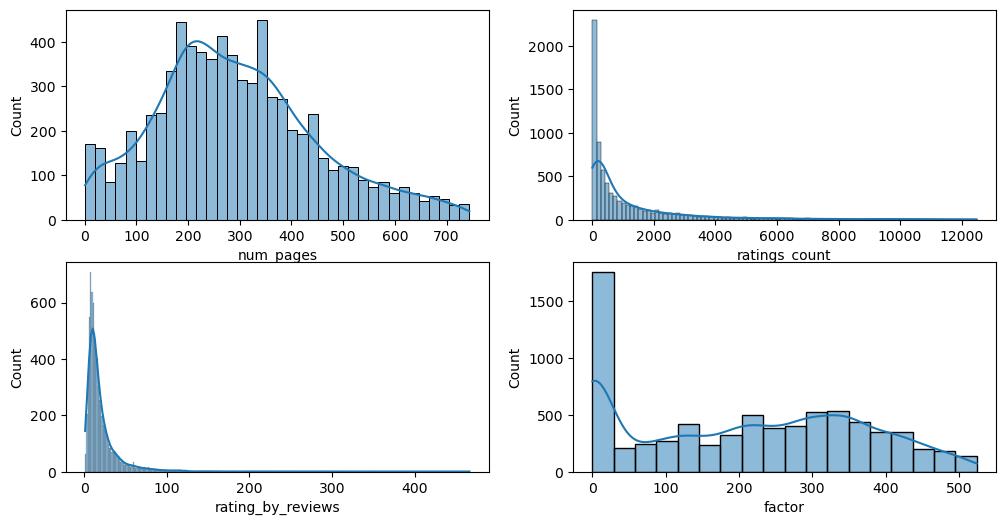

In [116]:
fig, axs = plt.subplots(2, 2, figsize=(12, 6))

sns.histplot(df_test['num_pages'], kde=True, ax=axs[0, 0])
sns.histplot(df_test['ratings_count'], kde=True, ax=axs[0, 1])
sns.histplot(df_test['rating_by_reviews'], kde=True, ax=axs[1, 0])
sns.histplot(df_test['factor'], kde=True, ax=axs[1, 1])

In [117]:
std_scaler = StandardScaler()

In [118]:
df_test['std_num_pages'] = std_scaler.fit_transform(df_test[['num_pages']])

In [119]:
df_test['log_ratings_count'] = np.log(df_test['ratings_count'])

In [120]:
df_test['log_rating_by_reviews'] = np.log(df_test['rating_by_reviews'])

In [121]:
df_test['std_factor'] = std_scaler.fit_transform(df_test[['factor']])

<Axes: xlabel='std_factor', ylabel='Count'>

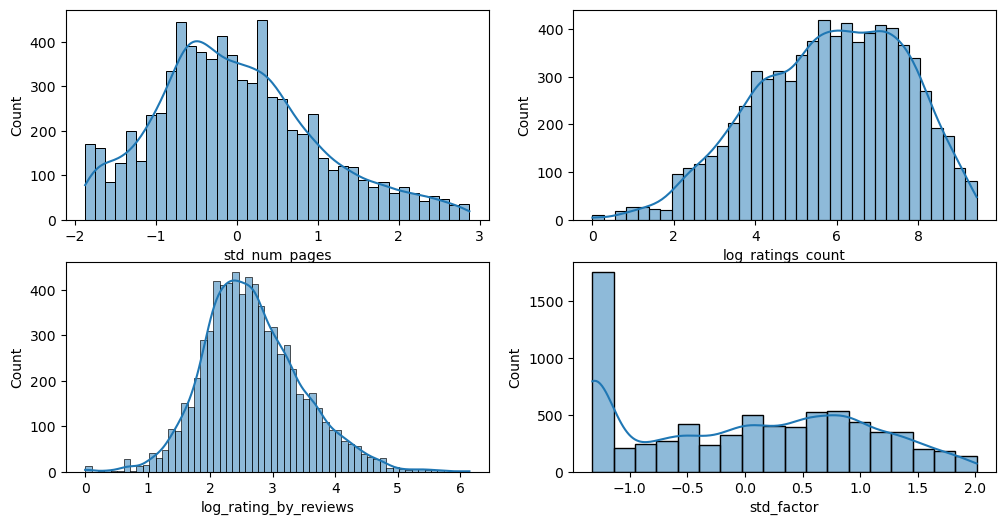

In [122]:
fig, axs = plt.subplots(2, 2, figsize=(12, 6))

sns.histplot(df_test['std_num_pages'], kde=True, ax=axs[0, 0])
sns.histplot(df_test['log_ratings_count'], kde=True, ax=axs[0, 1])
sns.histplot(df_test['log_rating_by_reviews'], kde=True, ax=axs[1, 0])
sns.histplot(df_test['std_factor'], kde=True, ax=axs[1, 1])

In [123]:
df['log_rating_by_reviews'] = df_test['log_rating_by_reviews']
df['std_num_pages']=df_test['std_num_pages']
df['std_factor']=df_test['std_factor']

<a id='210'></a>
### [2.10 ISBN](#210)
[Sommaire](#0)

Let's try to find an PUblisher ID inside the ISBN number.

1- We can check if the ISBN number is valid by computing the crontrol key from the first 12 digits and compare to the last digit.
2- By choice we'll work only with ISBN13 which is the standard since 2007.
    But some ISBN aren't valid or doesn't start with 978 which represent the book standard, for this specific cases (25) we can just remove them.
3- According to ISBN.org rules, we can apply the publisher regrouping.

other references to ISBN : 
https://www.isbn-international.org/sites/default/files/ISBN%20International%20Users%20Manual%20-%207th%20edition_absolutely_final.docx
https://www.isbn-international.org/range_file_generation

In [124]:
df.columns

Index(['bookID', 'title', 'authors', 'average_rating', 'isbn', 'isbn13',
       'language_code', 'num_pages', 'ratings_count', 'text_reviews_count',
       'publication_date', 'publisher', 'log_ratings_count',
       'rating_by_reviews', 'reviews_by_ratings', 'factor', 'month', 'year',
       'year_q1', 'year_q2', 'year_q3', 'year_q4', 'top_author', 'bad_author',
       'Author_Encoded_0', 'Author_Encoded_1', 'Author_Encoded_2',
       'Author_Encoded_3', 'Author_Encoded_4', 'Author_Encoded_5',
       'Author_Encoded_6', 'Author_Encoded_7', 'Author_Encoded_8',
       'Author_Encoded_9', 'Author_Encoded_10', 'log_rating_by_reviews',
       'std_num_pages', 'std_factor'],
      dtype='object')

In [125]:
# Check if the ISBN is valid, by adding a column to the dataset
# CHECK CONSISTENCY OF THE DATA BETWEEN ISBN-10 and ISBN-13

MyColumofpb=[]
nb_inconsistent=0

def is_ISBN10_Valid(Mystring):
    key_sum=0
    rest=0
    answer=False

    if len(Mystring)!=10:
        answer=False
    else:
        for j in range(9):
            key_sum += int(Mystring[j])*(10-j)    
        
        rest=key_sum%11

        if rest==0 :
            key='0'
        elif rest==1:
            key='X'
        else:
            key=str(11-rest)

        if Mystring[len(Mystring)-1]==key :
            answer=True
        else:
            answer=False
    return answer

def is_ISBN13_Valid(Mystring):
    key_sum=0
    rest=0
    answer=False

    if len(Mystring)!=13:
        answer=False
    else:
        for j in range(12):
            if (j+1)%2==0:
                key_sum += int(Mystring[j])*3    
            else:
                key_sum += int(Mystring[j])*1 

        rest=key_sum%10

        if rest==0 :
            key='0'
        else:
            key=str(10-rest)

        if Mystring[len(Mystring)-1]==key :
            answer=True
        else:
            answer=False

    return answer

# CHECK CONSISTENCY OF THE DATA ON ISBN-10 AND ISBN-13

MyColumofVerifISBN10=[]
MyColumofVerifISBN13=[]

#print(df_books.index.max())
for i in range(df.index.max()+1) :    
    My_ISBN10 = df.isbn.iloc[i]
    My_ISBN13 = df.isbn13.iloc[i]
    MyColumofVerifISBN10+=[is_ISBN10_Valid(My_ISBN10)]
    MyColumofVerifISBN13+=[is_ISBN13_Valid(My_ISBN13)]

df["ISBN_10_Chk"]=MyColumofVerifISBN10
df["ISBN_13_Chk"]=MyColumofVerifISBN13

In [126]:
print("NB of Wrong ISBN10  : "+ str(len(df.loc[df["ISBN_10_Chk"]==False,:])))
print("NB of Wrong ISBN13  : "+ str(len(df.loc[df["ISBN_13_Chk"]==False,:])))
print(df.loc[df["ISBN_10_Chk"]==False,'bookID'])
print(df.loc[df["ISBN_13_Chk"]==False,'bookID'])

NB of Wrong ISBN10  : 2
NB of Wrong ISBN13  : 2
6171    37063
6866    41824
Name: bookID, dtype: int64
1706    10255
3557    20781
Name: bookID, dtype: int64


In [127]:
# Create a column for each digit of ISBN  :
for j in range(10):
    df["ISBN10_D" + str(j)] = [i[j] for i in df.isbn]

for j in range(13):
    df["ISBN13_D" + str(j)] = [i[j] for i in df.isbn13]

In [128]:
df[['isbn13','ISBN13_D0', 'ISBN13_D1', 'ISBN13_D2','ISBN13_D3', 'ISBN13_D4', 'ISBN13_D5', 'ISBN13_D6', 'ISBN13_D7','ISBN13_D8', 'ISBN13_D9', 'ISBN13_D10', 'ISBN13_D11', 'ISBN13_D12']]

,isbn13,ISBN13_D0,ISBN13_D1,ISBN13_D2,ISBN13_D3,ISBN13_D4,ISBN13_D5,ISBN13_D6,ISBN13_D7,ISBN13_D8,ISBN13_D9,ISBN13_D10,ISBN13_D11,ISBN13_D12
0,9780439554893,9,7,8,0,4,3,9,5,5,4,8,9,3
1,9780976540601,9,7,8,0,9,7,6,5,4,0,6,0,1
2,9780739322208,9,7,8,0,7,3,9,3,2,2,2,0,8
3,9780767910439,9,7,8,0,7,6,7,9,1,0,4,3,9
4,9780618510825,9,7,8,0,6,1,8,5,1,0,8,2,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7426,9781560254416,9,7,8,1,5,6,0,2,5,4,4,1,6
7427,9780140110876,9,7,8,0,1,4,0,1,1,0,8,7,6
7428,9780140131963,9,7,8,0,1,4,0,1,3,1,9,6,3
7429,9780060878825,9,7,8,0,0,6,0,8,7,8,8,2,5


In [129]:
#Just Keep ISBN which starts by 978 according to ISBN standard.
df=df[(df['ISBN13_D0'] == '9') & (df['ISBN13_D1'] == '7') & (df['ISBN13_D2'] == '8')]

#For bad ISBN13, take the value of ISBN10 which is valid
for i in [1706,3557]:
    df.loc[i, 'ISBN13_D0'] = '9'
    df.loc[i, 'ISBN13_D1'] = '7'
    df.loc[i, 'ISBN13_D2'] = '8'
    df.loc[i, 'ISBN13_D3'] = df.loc[i, 'ISBN10_D0']
    df.loc[i, 'ISBN13_D4'] = df.loc[i, 'ISBN10_D1']
    df.loc[i, 'ISBN13_D5'] = df.loc[i, 'ISBN10_D2']
    df.loc[i, 'ISBN13_D6'] = df.loc[i, 'ISBN10_D3']
    df.loc[i, 'ISBN13_D7'] = df.loc[i, 'ISBN10_D4']
    df.loc[i, 'ISBN13_D8'] = df.loc[i, 'ISBN10_D5']
    df.loc[i, 'ISBN13_D9'] = df.loc[i, 'ISBN10_D6']
    df.loc[i, 'ISBN13_D10'] = df.loc[i, 'ISBN10_D7']
    df.loc[i, 'ISBN13_D11'] = df.loc[i, 'ISBN10_D8']


In [130]:
df_publisher_grouping=df[['ISBN13_D0', 'ISBN13_D1', 'ISBN13_D2', 'ISBN13_D3', 'ISBN13_D4',
       'ISBN13_D5', 'ISBN13_D6', 'ISBN13_D7', 'ISBN13_D8', 'ISBN13_D9',
       'ISBN13_D10', 'ISBN13_D11', 'year', 'publisher']]

In [131]:
#We remove the last digit of ISBN10 and 13.
df.drop('ISBN10_D9', axis=1, inplace=True)
df.drop('ISBN13_D12', axis=1, inplace=True)

In [132]:
df.language_code

0         eng
1       en-US
2         eng
3         eng
4         eng
        ...  
7426      eng
7427      eng
7428      eng
7429      eng
7430      spa
Name: language_code, Length: 7412, dtype: object

In [133]:
#A method is to parse xml file from "https://www.isbn-international.org/" to get the format of publisher ID according to the ISBN Standard
#Python code to illustrate parsing of XML files
# importing the required modules

import csv
import requests
import xml.etree.ElementTree as ET    
  
def parseXML(xmlfile):
  
    # create element tree object
    tree = ET.parse(xmlfile)
  
    # get root element
    root = tree.getroot()
  
    # create empty list for news items
    #newsitems = []
    rangeID_spec=[]


    # iterate news items
    for Group in root.findall('./RegistrationGroups/Group'):
        prefix=Group.find('Prefix').text
        Agency=Group.find('Agency').text
        #print(prefix)
        
        for Rules in Group.findall('Rules/Rule'):
            rule=Rules.find('Range').text
            #print('Rule Range :' + rule)
            length=Rules.find('Length').text
            #print('Rule length :' + length)

            # append news dictionary to news items list
            rangeID={   'Prefix': prefix,
                        'Agency': Agency,
                        'Range' : rule,
                        'Length': length}
            rangeID_spec.append(rangeID)
      
    # return news items list
    return rangeID_spec  

# parse xml file and create an df_RangeMessage containing all informations
RangeMessage = parseXML('RangeMessage.xml')
df_RangeMessage=pd.DataFrame(RangeMessage)
print(df_RangeMessage)

     Prefix            Agency            Range Length
0     978-0  English language  0000000-1999999      2
1     978-0  English language  2000000-2279999      3
2     978-0  English language  2280000-2289999      4
3     978-0  English language  2290000-3689999      3
4     978-0  English language  3690000-3699999      4
...     ...               ...              ...    ...
1545  979-8     United States  8500000-8849999      4
1546  979-8     United States  8850000-8999999      5
1547  979-8     United States  9000000-9849999      0
1548  979-8     United States  9850000-9899999      7
1549  979-8     United States  9900000-9999999      0

[1550 rows x 4 columns]


In [134]:
df_xml_ISBN=df[['isbn','isbn13','ISBN_10_Chk', 'ISBN_13_Chk']]
df_xml_ISBN


def Extract_From_ISBN_IDlength_Agency(ISBN13):
    for rule in df_RangeMessage.index:
        #print('rule :' + str(rule))
        prefix=df_RangeMessage.loc[rule,'Prefix'].replace('-','')
        agency=df_RangeMessage.loc[rule,'Agency']

        chaine = df_RangeMessage.loc[rule,'Range']
        debut, fin = chaine.split("-")
        range = [int(debut), int(fin)] 

        length = df_RangeMessage.loc[rule,'Length']
        #print('prefix :' + str(prefix))
        #print('Range :' + str(range))
        #print('Length :' + str(length))


        if len(prefix)<6 :
            if ISBN13[:len(prefix)]==prefix and int(ISBN13[len(prefix):11])<= int(fin) and int(ISBN13[len(prefix):11])>= int(debut) :
                return length
        elif len(prefix)>=6 :
            if ISBN13[:len(prefix)]==prefix and int(ISBN13[len(prefix):12])<= int(fin) and int(ISBN13[len(prefix):12])>= int(debut) :
                return length
    return None

def slice_isbn(row):  #Slice the ISBN with the len extracted from the ISBN rules, and returns None if len=0
    if row['id_publ_len'] !=0:
        return row['isbn13'][3:4 + row['id_publ_len']]
    else:
        return None

df_xml_ISBN['id_publ_len']=df_xml_ISBN['isbn13'].apply(lambda x: Extract_From_ISBN_IDlength_Agency(x))
df_xml_ISBN['id_publ_len'].fillna(0, inplace=True) #fill the None values by zeros
df_xml_ISBN['id_publ_len']= df_xml_ISBN['id_publ_len'].astype(int) # convert column to integer
df_xml_ISBN['publisher_owner_ID_xml']=df_xml_ISBN.apply(slice_isbn, axis=1)
#df_xml_ISBN['isbn13_test'].apply(lambda x: valid_rule(x))
#valid_rule('9780439554893')
    #df_xml_ISBN['publisher_owner_ID_xml']=df_xml_ISBN[df_xml_ISBN['isbn13'] lambda x: validrule(x)  ]


#We can see that all books satisfies at least one rule from ISBN.
df_xml_ISBN[df_xml_ISBN.id_publ_len==0]

C:\Users\albin\AppData\Local\Temp\ipykernel_304\3226411851.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_xml_ISBN['id_publ_len']=df_xml_ISBN['isbn13'].apply(lambda x: Extract_From_ISBN_IDlength_Agency(x))
C:\Users\albin\AppData\Local\Temp\ipykernel_304\3226411851.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_xml_ISBN['id_publ_len'].fillna(0, inplace=True) #fill the None values by zeros
C:\Users\albin\AppData\Local\Temp\ipykernel_304\3226411851.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Tr

,isbn,isbn13,ISBN_10_Chk,ISBN_13_Chk,id_publ_len,publisher_owner_ID_xml


In [135]:
#We can merge this two features to the main dataset 'df'
df_xml=pd.DataFrame(df_xml_ISBN['publisher_owner_ID_xml'])
df=df.merge(df_xml, how='inner', left_index=True, right_index=True)

In [136]:
# We can remove the columns which aren't necessary now : bookID, isbn and isbn13 since they are not meaningfull as per se
df.drop(['bookID','isbn', 'isbn13','ISBN10_D0', 'ISBN10_D1', 'ISBN10_D2', 'ISBN10_D3', 'ISBN10_D4',
       'ISBN10_D5', 'ISBN10_D6', 'ISBN10_D7', 'ISBN10_D8', 'ISBN13_D0',
       'ISBN13_D1', 'ISBN13_D2', 'ISBN13_D3', 'ISBN13_D4', 'ISBN13_D5',
       'ISBN13_D6', 'ISBN13_D7', 'ISBN13_D8', 'ISBN13_D9', 'ISBN13_D10',
       'ISBN13_D11', 'ISBN_10_Chk',
       'ISBN_13_Chk'], axis=1, inplace=True)

Let's take a look on this feature as we did for 'publishers'

<Axes: xlabel='title', ylabel='Count'>

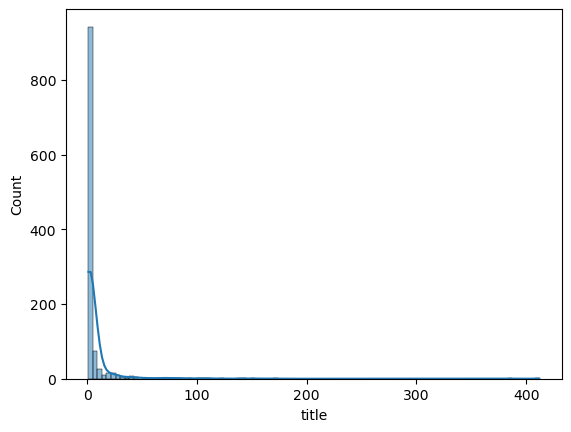

In [137]:
df_test3=df[['title','average_rating','publisher_owner_ID_xml']]
df_publi2 = df_test3.groupby('publisher_owner_ID_xml').agg({'title': 'count', 'average_rating': 'mean'}).sort_values(by='average_rating' ,ascending=True)
df_publi2 = df_publi2.reset_index()
df_publi2.sort_values(by='title')
sns.histplot(data=df_publi2, x='title', bins=100, kde=True)

In [138]:
df_publi2['title'].describe()

count    1140.000000
mean        6.501754
std        22.552621
min         1.000000
25%         1.000000
50%         1.000000
75%         4.000000
max       412.000000
Name: title, dtype: float64

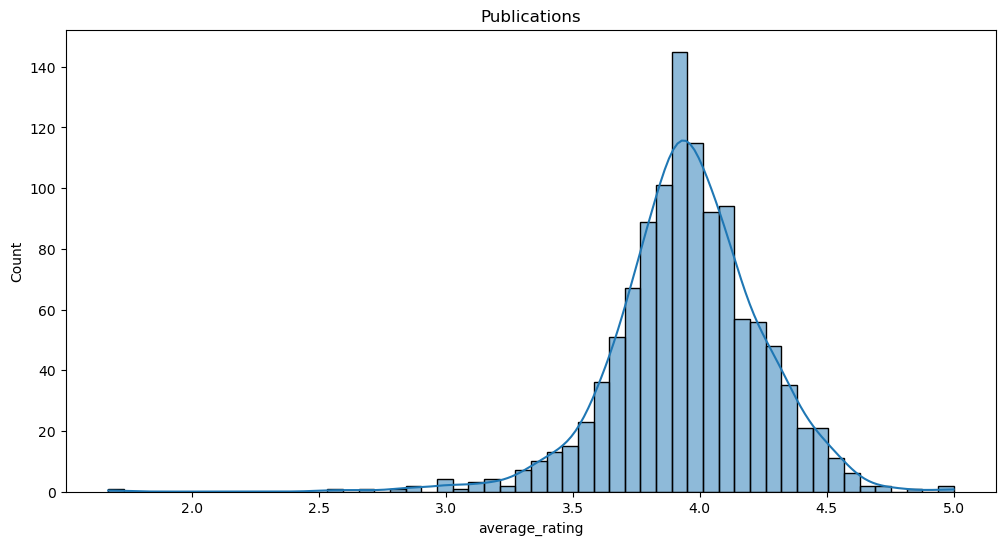

In [139]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.set_title('Publications')
sns.histplot(df_publi2.loc[df_publi2['title']>=1, 'average_rating'], kde=True, ax=ax)
plt.show()

'publisher_owner_ID_xml' seems to have a similar distribution than 'publisher', and give a way to regroup similar publisher by owner, see example for Penguin below.

In [140]:
df[df.publisher_owner_ID_xml=='014'][['publisher','publisher_owner_ID_xml']]

,publisher,publisher_owner_ID_xml
52,Penguin Books,014
68,Puffin,014
80,Penguin Books,014
101,Penguin Books,014
104,Penguin Books,014
...,...,...
7406,Penguin,014
7407,Penguin Books Ltd.,014
7425,Penguin Books,014
7427,Penguin Books,014


<a id='3'></a>
## [3. Training models](#3)
[Sommaire](#0)

In [141]:
columns_df1 = set(df.columns)
columns_df2 = set(df_test.columns)

# Identify Same and different columns
common_columns = columns_df1.intersection(columns_df2)
different_columns_df1 = columns_df1 - common_columns
different_columns_df2 = columns_df2 - common_columns

# Print result
print("Shared Columns :", common_columns)
print("Different columns in the global dataset :", different_columns_df1)
print("Different columns in the test dataset :", different_columns_df2)

Shared Columns : {'year_q3', 'std_factor', 'log_rating_by_reviews', 'year_q1', 'reviews_by_ratings', 'year', 'year_q2', 'ratings_count', 'log_ratings_count', 'text_reviews_count', 'top_author', 'bad_author', 'num_pages', 'year_q4', 'factor', 'std_num_pages', 'average_rating', 'rating_by_reviews'}
Different columns in the global dataset : {'publisher', 'publication_date', 'language_code', 'publisher_owner_ID_xml', 'Author_Encoded_1', 'Author_Encoded_8', 'title', 'Author_Encoded_3', 'month', 'Author_Encoded_0', 'authors', 'Author_Encoded_5', 'Author_Encoded_9', 'Author_Encoded_2', 'Author_Encoded_6', 'Author_Encoded_4', 'Author_Encoded_7', 'Author_Encoded_10'}
Different columns in the test dataset : set()


In [142]:
# Find best combination of all features : Using Gradient Boosting 
import random

all_features_possible = ['num_pages',
       'ratings_count', 'text_reviews_count',
       'log_ratings_count', 'reviews_by_ratings',
       'factor', 'month', 'year', 'year_q1', 'year_q2', 'year_q3', 'year_q4',
       'top_author', 'bad_author',
       'Author_Encoded_0', 'Author_Encoded_1',
       'Author_Encoded_2', 'Author_Encoded_3', 'Author_Encoded_4',
       'Author_Encoded_5', 'Author_Encoded_6', 'Author_Encoded_7',
       'Author_Encoded_8', 'Author_Encoded_9', 'Author_Encoded_10',
       'log_rating_by_reviews', 'std_num_pages', 'std_factor',
       'publisher_owner_ID_xml']

random_state = 42
test_size = 0.25

max_iter = 100

best_score_MSE = 1000
best_features =[]


for i in range(0,max_iter):
    nombre_elements = random.randint(1, len(all_features_possible))  # Choisit un nombre aléatoire entre 1 et la longueur de la liste
    elements_choisis = random.sample(all_features_possible, nombre_elements)
    X = df[elements_choisis]
    Y = df['average_rating']

    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=random_state)

    g_boost = GradientBoostingRegressor(learning_rate=0.01, n_estimators=500, max_depth=4, verbose=True, random_state=random_state)
    g_boost.fit(X_train, y_train)
    g_boost_pred = g_boost.predict(X_test)
    g_boost_mse = mean_squared_error(y_test, g_boost_pred)

    if(g_boost_mse < best_score_MSE):
       best_score_MSE = g_boost_mse
       best_features =elements_choisis

print("Best score MSE : ",best_score_MSE, "\n Best features : ", best_features )

      Iter       Train Loss   Remaining Time 
         1           0.0798            3.36s
         2           0.0797            3.10s
         3           0.0796            2.89s
         4           0.0795            2.88s
         5           0.0794            2.85s
         6           0.0793            2.84s
         7           0.0792            2.83s
         8           0.0791            2.85s
         9           0.0790            2.84s
        10           0.0789            2.84s
        20           0.0781            2.72s
        30           0.0773            2.59s
        40           0.0767            2.52s
        50           0.0762            2.60s
        60           0.0758            2.52s
        70           0.0753            2.43s
        80           0.0749            2.34s
        90           0.0746            2.26s
       100           0.0742            2.19s
       200           0.0720            1.59s
       300           0.0706            1.05s
       40

In [143]:
old_features = ['std_num_pages', 'log_ratings_count','log_rating_by_reviews','std_factor', 'top_author', 'bad_author', 
                'year_q1', 'year_q2', 'year_q3', 'year_q4']

features = ['top_author', 'reviews_by_ratings', 'log_rating_by_reviews', 'ratings_count',
                 'text_reviews_count', 'bad_author', 'std_num_pages', 'year_q4', 'log_ratings_count', 'year_q2', 'std_factor', 'year_q1', 
                 'num_pages', 'factor', 'year', 'year_q3', 'rating_by_reviews','publisher_owner_ID_xml']

In [144]:
df.columns

Index(['title', 'authors', 'average_rating', 'language_code', 'num_pages',
       'ratings_count', 'text_reviews_count', 'publication_date', 'publisher',
       'log_ratings_count', 'rating_by_reviews', 'reviews_by_ratings',
       'factor', 'month', 'year', 'year_q1', 'year_q2', 'year_q3', 'year_q4',
       'top_author', 'bad_author', 'Author_Encoded_0', 'Author_Encoded_1',
       'Author_Encoded_2', 'Author_Encoded_3', 'Author_Encoded_4',
       'Author_Encoded_5', 'Author_Encoded_6', 'Author_Encoded_7',
       'Author_Encoded_8', 'Author_Encoded_9', 'Author_Encoded_10',
       'log_rating_by_reviews', 'std_num_pages', 'std_factor',
       'publisher_owner_ID_xml'],
      dtype='object')

<a id='31'></a>
### [3.1 Linear Regression](#31)
[Sommaire](#0)

In [145]:
random_state = 42
test_size = 0.25
X = df[best_features]
Y = df['average_rating']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=random_state)

linreg = LinearRegression()

linreg.fit(X_train, y_train)
linreg_pred = linreg.predict(X_test)

linreg_score = round(linreg.score(X_test, y_test), 4)
print(linreg_score)

0.1689


<a id='32'></a>
### [3.2 Decision Tree](#32)
[Sommaire](#0)

In [146]:
tree = DecisionTreeRegressor(max_depth=5, random_state=random_state)

tree.fit(X_train, y_train)
tree_pred = tree.predict(X_test)

tree_score = round(tree.score(X_test, y_test), 4)
print(f"Linear Regression score : {linreg_score}\nDecision Tree score : {tree_score}")

Linear Regression score : 0.1689
Decision Tree score : 0.1314


<a id='33'></a>
### [3.3 Random Forest](#33)
[Sommaire](#0)

In [147]:
forest = RandomForestRegressor(max_depth=5, oob_score=True, random_state=random_state)

forest.fit(X_train, y_train)
forest_pred = forest.predict(X_test)

forest_score = round(forest.score(X_test, y_test), 4)
print(f"Linear Regression score : {linreg_score}\nDecision Tree score : {tree_score}")
print(f"Random Forest score : {forest_score}")

Linear Regression score : 0.1689
Decision Tree score : 0.1314
Random Forest score : 0.1908


#### Random Forest Using GridSearchCV to optimize parameters

In [148]:
# Using GridSearchCV to Optimize the parameters :  WARNING : Long time Execution (4 min)

# Optimisation parameters : 
param_grid_random_forest = {
    'n_estimators' : [240,250,260], #Nb of trees
    'max_depth' : [None,3,5 ],       #Max depth of the trees
    'min_samples_split' : [18,19,20],    #Min number of samples required to plsit an internal node
    'min_samples_leaf' : [3,4,5]       #Min number of samples required to be at a leaf node
}
model_random_forest = RandomForestRegressor(random_state = 42)

#Fit the best model 
grid_search_random_forest = GridSearchCV(estimator = model_random_forest , param_grid = param_grid_random_forest, cv = 5 , scoring = 'neg_mean_squared_error', n_jobs = -1)
grid_search_random_forest.fit(X_train,y_train)

# Output 
best_param_random_forest = grid_search_random_forest.best_params_
best_model_random_forest = grid_search_random_forest.best_estimator_
print("Best param random forest : ", best_param_random_forest)
print("Best model random forest : ",best_model_random_forest)

Best param random forest :  {'max_depth': None, 'min_samples_leaf': 5, 'min_samples_split': 20, 'n_estimators': 260}
Best model random forest :  RandomForestRegressor(min_samples_leaf=5, min_samples_split=20,
                      n_estimators=260, random_state=42)


In [149]:
random_forest_grid_search_pred = best_model_random_forest.predict(X_test)

mse_random_forest = mean_squared_error(y_test, random_forest_grid_search_pred)
r_squared_random_forest = r2_score(y_test, random_forest_grid_search_pred)
print("Mean squared Error random forest : ",mse_random_forest)
print("R2 squarred error random forest : ",r_squared_random_forest)
# Classical Random Forest
# Random Forest
# RMSE : 0.2741
# MSE : 0.0751
# MAE : 0.2047
# R2 : 0.1868
# RMSLE : 0.0576

# # PCA Random Forest : 
# Mean squared Error random forest :  0.07687726348584888
# R2 squarred error random forest :  0.1860946891890609

Mean squared Error random forest :  0.0715467216510244
R2 squarred error random forest :  0.22540053998761334


<a id='34'></a>
### [3.4 Gradient Boosting](#34)
[Sommaire](#0)

In [150]:
g_boost = GradientBoostingRegressor(learning_rate=0.01, n_estimators=500, max_depth=4, verbose=True, random_state=random_state)
g_boost.fit(X_train, y_train)
g_boost_pred = g_boost.predict(X_test)

g_boost_score = round(g_boost.score(X_test, y_test), 4)
print(f"Linear Regression score : {linreg_score}\nDecision Tree score : {tree_score}")
print(f"Random Forest score : {forest_score}\nGradient Boosting score : {g_boost_score}")

      Iter       Train Loss   Remaining Time 
         1           0.0797            7.13s
         2           0.0794            6.79s
         3           0.0791            6.84s
         4           0.0789            6.85s
         5           0.0786            6.86s
         6           0.0783            6.77s
         7           0.0781            6.71s
         8           0.0778            6.78s
         9           0.0776            6.70s
        10           0.0773            6.75s
        20           0.0751            6.44s
        30           0.0732            6.32s
        40           0.0715            6.14s
        50           0.0699            6.02s
        60           0.0684            5.87s
        70           0.0671            5.73s
        80           0.0660            5.58s
        90           0.0650            5.48s
       100           0.0641            5.39s
       200           0.0590            4.09s
       300           0.0564            2.71s
       40

<a id='35'></a>
### [3.5 PCA](#35)
[Sommaire](#0)


Principal Component Anylysis is mostly used in cases where you have a high dimensional matrix as dataset. It is used to reduce the number of attribute by creating new features which are linear combination of the true features. 

In [151]:
# We have first to keep only numerical values and drop string, date ...
# df_pca = df.copy()
# # print(df_pca.dtypes)
# df_pca = df_pca.astype({'publisher_owner_ID_xml':'int'})

# string_columns = [col for col in df_pca.columns if (df_pca[col].dtype == 'string' or df_pca[col].dtype== 'object')]

# df_pca.drop(columns=string_columns, inplace=True)
# df_pca.drop(columns='publication_date', inplace=True)
# df_pca.drop(columns='rating_by_reviews', inplace=True) #Has inf values 

# On the previous example, I just kept some columns from the original dataset because I didn't know what to keep and what to dropp. 
# There is a method called PCA Principal component analysis which allows to keep only the columns that are the most valuable to the model. 
# The parameter n_components if between 0 and 1 will determine the columns used by selecting the number of components such that the amount of variance that needs to be explained is greater than the percentage specified by n_components

# 1 : Let's first Split X and y  : 

# X = df_pca.loc[:, df_pca.columns != "average_rating"].values
# Y = df_pca.average_rating.values

# 2 : Normalize the data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
normalized_data = scaler.fit_transform(X)

# 3 : Create PCA Object
# We will say that we want to keep at least 80% of the sum of variance. We could also decide to get in the end only 10 columns using the same parameters
num_component = 0.8 
pca = PCA(n_components=num_component)

# 4 : Fit and Transform the data
X_pca = pca.fit_transform(normalized_data)

explained_variance_ratio = pca.explained_variance_ratio_
print("Explained Variance Ratio:", explained_variance_ratio)

X_train_pca, X_test_pca, Y_train, Y_test = train_test_split(X_pca, Y, test_size= 0.2, random_state= 42)

# original_data = pca.inverse_transform(X_pca) #Get the original Data


Explained Variance Ratio: [0.13838    0.09801898 0.08859215 0.05827173 0.05579243 0.05511796
 0.05031082 0.04905975 0.04840543 0.04790461 0.04740467 0.04648342
 0.04393007]


In [152]:
# Get the principal components (directions) in the original feature space
principal_components_directions = pca.components_

# Print the principal components and their corresponding original feature names
for component_num, component in enumerate(principal_components_directions):
    original_feature_names = list(X.columns)  # Replace with your actual column/feature names
    top_features_indices = component.argsort()[::-1][:3]  # Specify how many top features to show
    top_features = [original_feature_names[index] for index in top_features_indices]
    
    print(f"Principal Component {component_num + 1}: Top Features - {top_features}")

Principal Component 1: Top Features - ['log_ratings_count', 'ratings_count', 'text_reviews_count']
Principal Component 2: Top Features - ['year_q3', 'std_num_pages', 'num_pages']
Principal Component 3: Top Features - ['year_q3', 'ratings_count', 'year_q4']
Principal Component 4: Top Features - ['bad_author', 'Author_Encoded_7', 'Author_Encoded_5']
Principal Component 5: Top Features - ['year_q4', 'Author_Encoded_0', 'std_factor']
Principal Component 6: Top Features - ['top_author', 'Author_Encoded_4', 'log_rating_by_reviews']
Principal Component 7: Top Features - ['Author_Encoded_8', 'Author_Encoded_3', 'Author_Encoded_7']
Principal Component 8: Top Features - ['Author_Encoded_8', 'Author_Encoded_4', 'Author_Encoded_0']
Principal Component 9: Top Features - ['Author_Encoded_5', 'Author_Encoded_9', 'log_rating_by_reviews']
Principal Component 10: Top Features - ['Author_Encoded_0', 'Author_Encoded_8', 'Author_Encoded_1']
Principal Component 11: Top Features - ['Author_Encoded_0', 'Autho

In [153]:
# Let's try now again a random Forest with our new df WARNING : Long Time excution  (7 min)

model_random_forest_pca = RandomForestRegressor(random_state = 42)

# Optimisation parameters : 
param_grid_random_forest = {
    'n_estimators' : [200,250], #Nb of trees
    'max_depth' : [None,5,10,15],       #Max depth of the trees
    'min_samples_split' : [20,30,40],    #Min number of samples required to plsit an internal node
    'min_samples_leaf' : [5,10,15]       #Min number of samples required to be at a leaf node
}

#Fit the best model 
grid_search_random_forest_pca = GridSearchCV(estimator = model_random_forest_pca , param_grid = param_grid_random_forest, cv = 5 , scoring = 'neg_mean_squared_error', n_jobs = -1)
grid_search_random_forest_pca.fit(X_train_pca,Y_train)


# Output 
best_param_random_forest_pca = grid_search_random_forest_pca.best_params_
best_model_random_forest_pca = grid_search_random_forest_pca.best_estimator_
print("Best param random forest : ", best_param_random_forest_pca)
print("Best model random forest : ",best_model_random_forest_pca )

random_forest_pca_pred = best_model_random_forest_pca.predict(X_test_pca)

mse_random_forest_pca = mean_squared_error(Y_test, random_forest_pca_pred)
r_squared_random_forest_pca = r2_score(Y_test, random_forest_pca_pred)
print("Mean squared Error random forest : ",mse_random_forest_pca)
print("R2 squarred error random forest : ",r_squared_random_forest_pca)

Best param random forest :  {'max_depth': 15, 'min_samples_leaf': 10, 'min_samples_split': 20, 'n_estimators': 250}
Best model random forest :  RandomForestRegressor(max_depth=15, min_samples_leaf=10, min_samples_split=20,
                      n_estimators=250, random_state=42)
Mean squared Error random forest :  0.07666183261999338
R2 squarred error random forest :  0.18837547180126535


<a id='4'></a>
## [4. Models analysis](#4)
[Sommaire](#0)

In [154]:
model_pred_dic = {'Linear Regression': linreg_pred,
                  'Decision Tree': tree_pred,
                  'Random Forest': forest_pred,
                  'Random Forest with GridSearch CV' : random_forest_grid_search_pred,
                  'Gradient Boosting': g_boost_pred}
for model, preds in model_pred_dic.items():
    print(model)
    regression_metrics(y_test, preds)
    print('-'*30)

Linear Regression
RMSE : 0.2771
MSE : 0.0768
MAE : 0.2088
R2 : 0.1689
RMSLE : 0.0582
------------------------------
Decision Tree
RMSE : 0.2833
MSE : 0.0802
MAE : 0.2144
R2 : 0.1314
RMSLE : 0.0595
------------------------------
Random Forest
RMSE : 0.2734
MSE : 0.0747
MAE : 0.2049
R2 : 0.1908
RMSLE : 0.0575
------------------------------
Random Forest with GridSearch CV
RMSE : 0.2675
MSE : 0.0715
MAE : 0.1997
R2 : 0.2254
RMSLE : 0.0563
------------------------------
Gradient Boosting
RMSE : 0.2659
MSE : 0.0707
MAE : 0.1986
R2 : 0.2345
RMSLE : 0.0561
------------------------------


<a id="4.1"></a>
### [4.1 Residuals analysis](#4.1)
[Sommaire](#0)

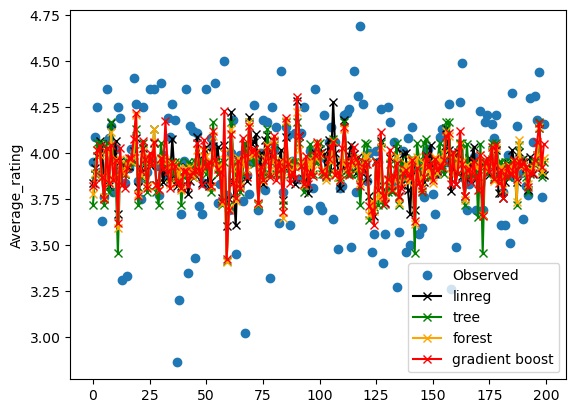

In [155]:
z = 200
plt.plot(y_test.values[:z], 'o', label='Observed')
plt.plot(linreg_pred[:z], 'x-', color='black', label='linreg')
plt.plot(tree_pred[:z], 'x-', color='green', label='tree')
plt.plot(forest_pred[:z], 'x-', color='orange', label='forest')
plt.plot(g_boost_pred[:z], 'x-', color='red', label='gradient boost')
plt.ylabel('Average_rating')
plt.legend()
plt.show()

Text(0, 0.5, 'Error in % ')

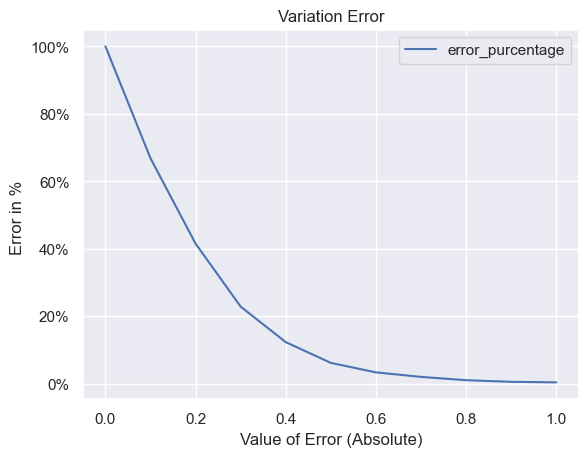

In [156]:
#Evolution of the error 
import matplotlib.ticker as mtick

sns.set()
diff_error = np.abs(forest_pred-y_test)
error_purcentage = []
value_error = np.arange(0, 1.1, 0.1)

for j in value_error:
    big_error = [i  for i in diff_error if i>j]
    error_pur = 100 * len(big_error)/ len(diff_error)
    error_purcentage.append(error_pur)

d = {'value_error' : value_error, 'error_purcentage' : error_purcentage}
df_plot = pd.DataFrame(data =d)

ax = df_plot.plot(x= 'value_error', y='error_purcentage')
fmt = '%.0f%%' # Format you want the ticks, e.g. '40%'
yticks = mtick.FormatStrFormatter(fmt)
ax.yaxis.set_major_formatter(yticks)
plt.title("Variation Error")
plt.xlabel("Value of Error (Absolute)")
plt.ylabel("Error in % ")

As we can see, the error goes descending really quick, 80% of our error is between 0 and 0.3 on the difference of y_test and y_pred

In [157]:
linreg_residuals = y_test.values - linreg_pred
tree_residuals = y_test.values - tree_pred
forest_residuals = y_test.values - forest_pred
g_boost_residuals = y_test.values - g_boost_pred
residuals_list = [linreg_residuals, tree_residuals, forest_residuals, g_boost_residuals]

In linear regression, there is one big assumption about residuals : 
- <u>They are independent and normally distributed</u>

The following graph validate this assumption, as we see that they are normally distributed and that there is no specific pattern in our residuals.    
Thus, our model have catch all the the deterministic, predictive information. Meaning that all that is left behind is stochastic and so completely random and unpredictible. Hence we want our residuals to **follow a normal distribution.**

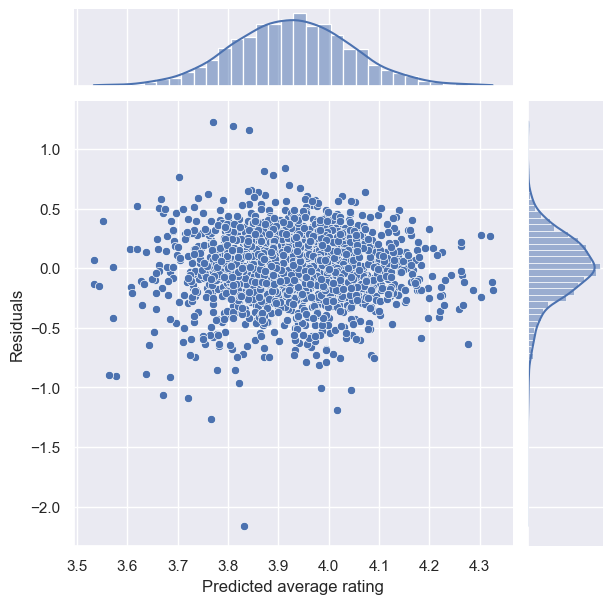

In [158]:
linreg_grid = sns.JointGrid(x=linreg_pred, y=linreg_residuals)
linreg_grid.plot_joint(sns.scatterplot)
linreg_grid.plot_marginals(sns.histplot, kde=True)
linreg_grid.set_axis_labels(xlabel='Predicted average rating', ylabel='Residuals')
plt.show()

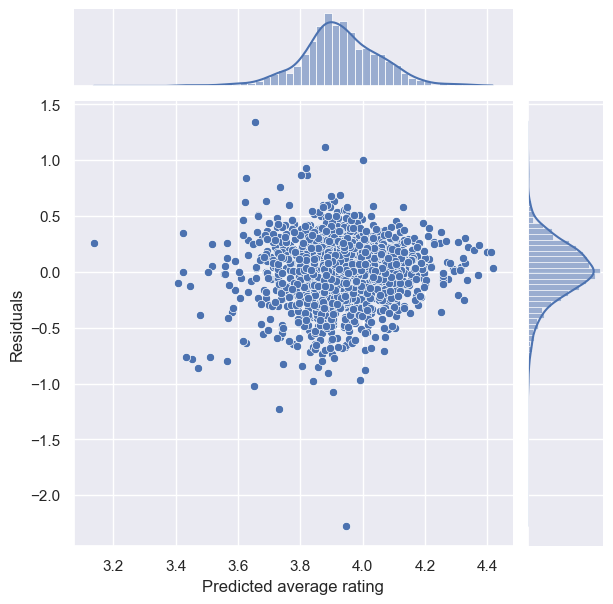

In [159]:
g_boost_grid = sns.JointGrid(x=g_boost_pred, y=g_boost_residuals)
g_boost_grid.plot_joint(sns.scatterplot)
g_boost_grid.plot_marginals(sns.histplot, kde=True)
g_boost_grid.set_axis_labels(xlabel='Predicted average rating', ylabel='Residuals')
plt.show()

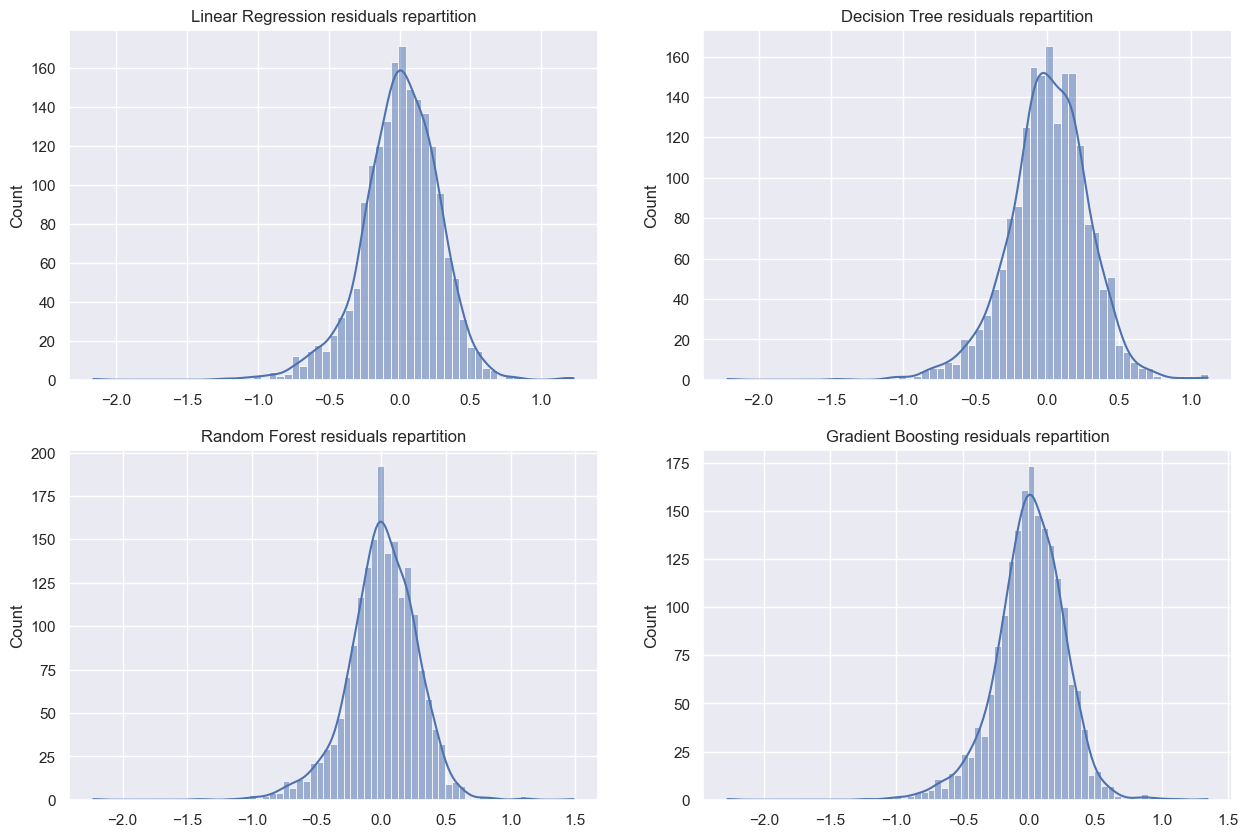

In [160]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

axs[0, 0].set_title('Linear Regression residuals repartition')
sns.histplot(linreg_residuals, kde=True, ax=axs[0, 0])
axs[0, 1].set_title('Decision Tree residuals repartition')
sns.histplot(tree_residuals, kde=True, ax=axs[0, 1])
axs[1, 0].set_title('Random Forest residuals repartition')
sns.histplot(forest_residuals, kde=True, ax=axs[1, 0])
axs[1, 1].set_title('Gradient Boosting residuals repartition')
sns.histplot(g_boost_residuals, kde=True, ax=axs[1, 1])
plt.show()

In [161]:
for model, residual in zip(model_pred_dic, residuals_list):
    print(model)
    print(f"Residuals mean : {residual.mean():.4f}\nResiduals std : {residual.std():.4f}")
    print('-'*40)

Linear Regression
Residuals mean : 0.0054
Residuals std : 0.2770
----------------------------------------
Decision Tree
Residuals mean : 0.0064
Residuals std : 0.2832
----------------------------------------
Random Forest
Residuals mean : 0.0057
Residuals std : 0.2733
----------------------------------------
Random Forest with GridSearch CV
Residuals mean : 0.0038
Residuals std : 0.2659
----------------------------------------


In [162]:
g_boost.feature_names_in_

array(['Author_Encoded_4', 'Author_Encoded_8', 'Author_Encoded_7',
       'Author_Encoded_3', 'Author_Encoded_0', 'log_ratings_count',
       'log_rating_by_reviews', 'bad_author', 'year_q2', 'top_author',
       'num_pages', 'Author_Encoded_5', 'ratings_count', 'std_factor',
       'Author_Encoded_1', 'text_reviews_count', 'year_q4', 'year',
       'year_q3', 'Author_Encoded_9', 'std_num_pages'], dtype=object)

In [163]:
g_boost.feature_importances_

array([1.65911744e-03, 3.33660858e-03, 2.80426502e-03, 3.70139614e-03,
       2.50651542e-03, 3.13561088e-02, 1.63000782e-01, 3.70615718e-02,
       3.29016807e-04, 4.82698505e-02, 6.17407557e-02, 1.80918757e-03,
       3.26196800e-02, 4.76454540e-01, 3.60743893e-03, 1.98630062e-02,
       2.35843679e-03, 3.68543064e-02, 1.95274588e-03, 7.15378655e-03,
       6.15608833e-02])

In [164]:
for feature, importance in zip(g_boost.feature_names_in_, g_boost.feature_importances_):
    print(f"{feature} : {importance}")
    print('-'*40)

Author_Encoded_4 : 0.001659117443620954
----------------------------------------
Author_Encoded_8 : 0.0033366085813663965
----------------------------------------
Author_Encoded_7 : 0.002804265022184739
----------------------------------------
Author_Encoded_3 : 0.003701396141359056
----------------------------------------
Author_Encoded_0 : 0.0025065154177658987
----------------------------------------
log_ratings_count : 0.03135610880310848
----------------------------------------
log_rating_by_reviews : 0.16300078195150963
----------------------------------------
bad_author : 0.03706157175290036
----------------------------------------
year_q2 : 0.00032901680700983
----------------------------------------
top_author : 0.04826985048984178
----------------------------------------
num_pages : 0.061740755698704124
----------------------------------------
Author_Encoded_5 : 0.0018091875666632422
----------------------------------------
ratings_count : 0.03261967998202022
----------------